In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.quantum_info import Statevector

/run/media/wallace/Personal/Documents (E)/Web Development/Resume Projects/Implement/qml-major-project/qml-anomaly-detection/.venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
ccf_df = pd.read_csv('ccfraud/creditcard.csv')
ccf_df.shape

(284807, 31)

In [5]:
diabetes_df = pd.read_csv('diabetes/diabetes.csv')
diabetes_df.shape

(768, 9)

In [3]:
kdd_df = pd.read_csv('KDD Cup 1999/kddcup.data.csv')
kdd_df.shape

(4898431, 42)

## Credit Card Fraud dataset analysis

### Classical EDA

#### Class Imbalance Check

/tmp/ipykernel_10722/2086142342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=ccf_df, palette='coolwarm')


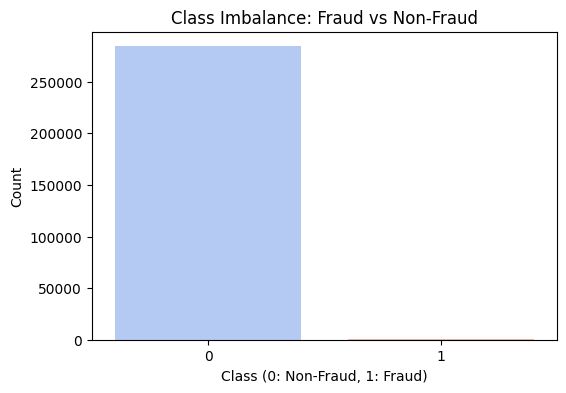

Non-Fraud Count: 284315
Fraud Count: 492


In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(hue='Class', data=ccf_df, palette='coolwarm', legend=False)
plt.title('Class Imbalance: Fraud vs Non-Fraud')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

print(f"Non-Fraud Count: {ccf_df.loc[ccf_df['Class'] == 0, 'Class'].count()}")
print(f"Fraud Count: {ccf_df.loc[ccf_df['Class'] == 1, 'Class'].count()}")

**Insight** <br>
There is imbalance in the fraud and non-fraud datapoints in the dataset, with data beig skewed towards the non-fraudulent datapoints.

**Problem Observed** <br>
With a significantly large number of non-fraudulent transactions, may result in the ML classifier model not learning the fraudulent data during the training process

#### Correlation Matrix (Heatmap)

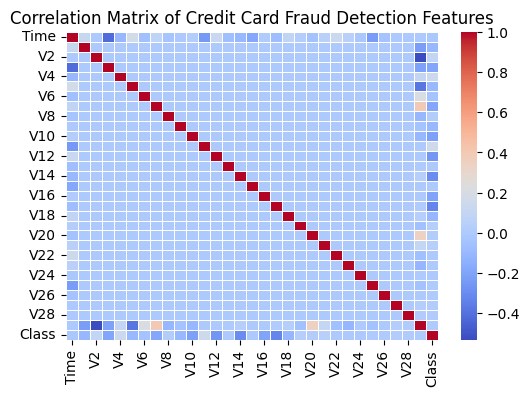

In [45]:
plt.figure(figsize=(6, 4))
corr_matrix = ccf_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Credit Card Fraud Detection Features')
plt.show()

**Description** <br>
The correlation matrix displays the correlation between each pair of features in the dataset.
Darker red squares indicate a strong positive correlation, while darker blue squares indicate a strong negative correlation.

**Insight** <br>
Most features appear to have little to no correlation with each other (close to zero), indicating they are largely independent.
There are a few mild correlations, which may provide insights into feature importance or dependencies when building a predictive model.

**Problem** <br>
Feature independence in this dataset implies that the relationships between features might be complex, requiring sophisticated models to detect patterns that identify fraudulent transactions.

#### Distribution of `Amount` Feature

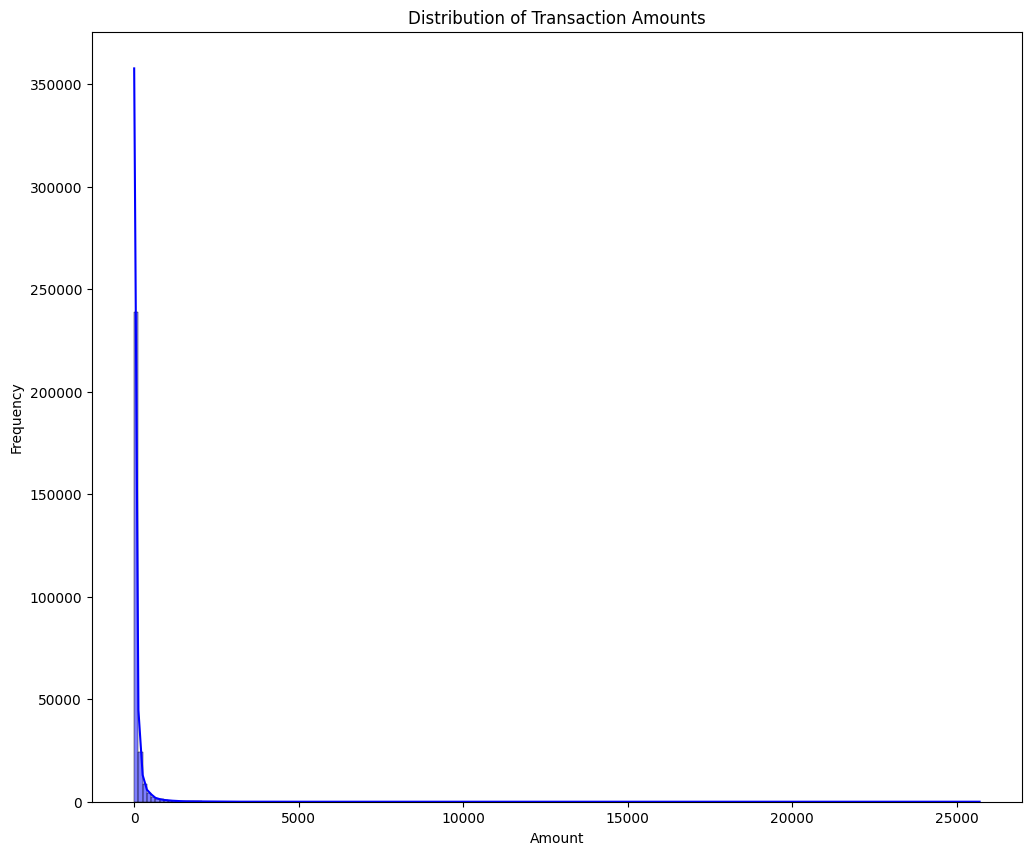

In [42]:
plt.figure(figsize=(12, 10))
sns.histplot(ccf_df['Amount'], bins=200, color='blue', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

**Description** <br>
The histogram visualizes the distribution of transaction amounts in the dataset, showing how frequently each transaction amount appears.

**Insight** <br>
The distribution is highly skewed to the right, with the majority of transactions being of low value. This is typical in real-world financial transactions.

**Problem** <br>
The skewness in transaction amounts can lead to biased predictions if not properly handled, as models might focus too much on the majority class (low-value transactions) and overlook fraudulent high-value transactions.

#### Time Vs Amount (Fraud and Non-Fraud) --> Slow | but does not skip any data

/media/manoj/Personal/Documents (E)/Web Development/Resume Projects/Implement/qml-major-project/qml-anomaly-detection/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


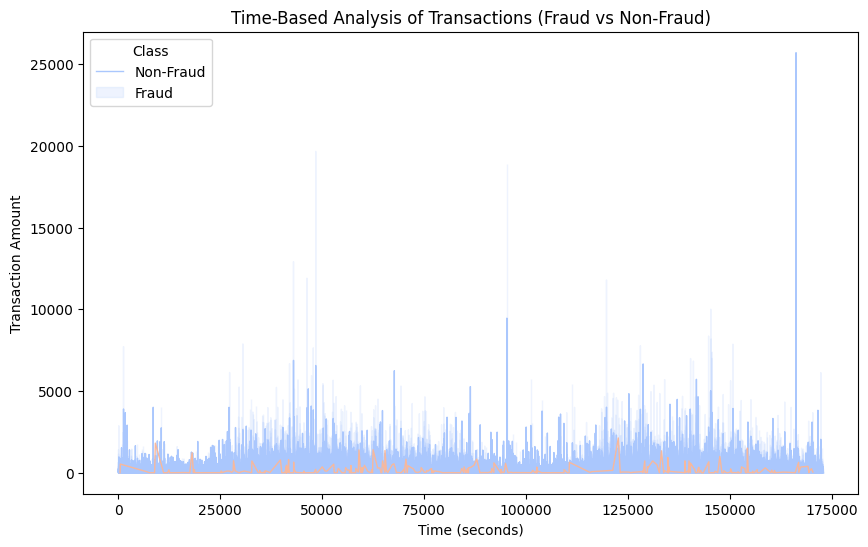

In [43]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Time', y='Amount', hue='Class', data=ccf_df, palette='coolwarm', linewidth=1)
plt.title('Time-Based Analysis of Transactions (Fraud vs Non-Fraud)')
plt.xlabel('Time (seconds)')
plt.ylabel('Transaction Amount')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()

#### Time Vs Amount (Fraud and Non-Fraud) --> Fast (using dask.dataframe) | but loses some data

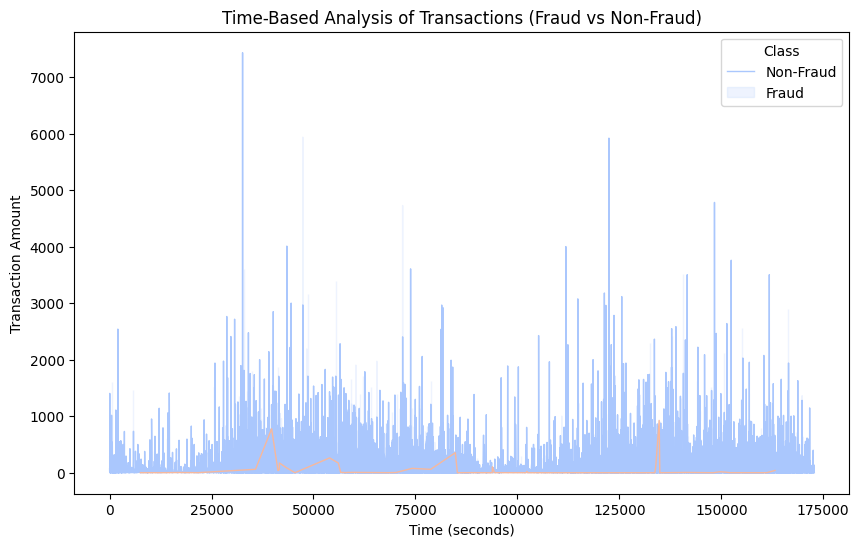

In [11]:
# Sample the data (10% of the data points)
ccf_ddf = dd.from_pandas(ccf_df, npartitions=10)
sample_fraction = 0.1 # 10%
ccf_sample = ccf_ddf.sample(frac=sample_fraction).compute()

# 4. Time-Based Analysis
plt.figure(figsize=(10, 6))
sns.lineplot(x='Time', y='Amount', hue='Class', data=ccf_sample, palette='coolwarm', linewidth=1)
plt.title('Time-Based Analysis of Transactions (Fraud vs Non-Fraud)')
plt.xlabel('Time (seconds)')
plt.ylabel('Transaction Amount')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()

**Description** <br>
The line plot compares transaction amounts over time for both fraudulent and non-fraudulent transactions.

**Insight** <br>
Non-fraudulent transactions occur more frequently and in larger numbers throughout the timeline, while fraudulent transactions are scattered sparsely across the timeline with lower values.

**Problem** <br>
The time-based separation of fraudulent transactions indicates that fraud detection might require temporal patterns to be considered, as frauds do not happen uniformly over time.

#### TimeInterval (hours) vs TransactionCount (number of transactions in that hour) (Fraud and Non-Fraud) --> FAST (using dask.dataframe)

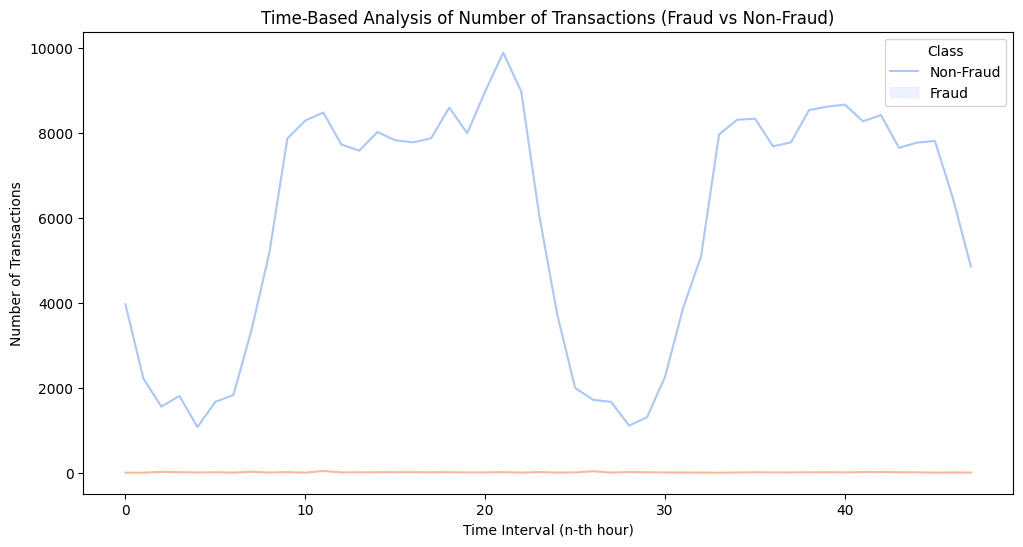

In [16]:
time_bins = 3600  # 1-hour intervals
ccf_ddf['TimeInterval'] = (ccf_ddf['Time'] // time_bins).astype(int)

# Group the data by 'TimeInterval' and 'Class' to count the number of transactions in each interval
time_based_counts = ccf_ddf.groupby(['TimeInterval', 'Class']).size().compute().reset_index(name='TransactionCount')

# Plot the time-based analysis of the number of transactions (frequency) for each class
plt.figure(figsize=(12, 6))
sns.lineplot(x='TimeInterval', y='TransactionCount', hue='Class', data=time_based_counts, palette='coolwarm', linewidth=1.5)
plt.title('Time-Based Analysis of Number of Transactions (Fraud vs Non-Fraud)')
plt.xlabel('Time Interval (n-th hour)')
plt.ylabel('Number of Transactions')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()

**Description** <br>
The line plot compares number of transactions over time for both fraudulent and non-fraudulent transactions.

**Insight** <br>
Non-fraudulent transactions occur more frequently and in larger numbers throughout the timeline, while fraudulent transactions are scattered sparsely across the timeline with lower values.

**Problem** <br>
The time-based separation of fraudulent transactions indicates that fraud detection might require temporal patterns to be considered, as frauds do not happen uniformly over time.

#### Box Plot for Outlier Detection

/tmp/ipykernel_10722/3408132874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=ccf_df, palette='coolwarm')


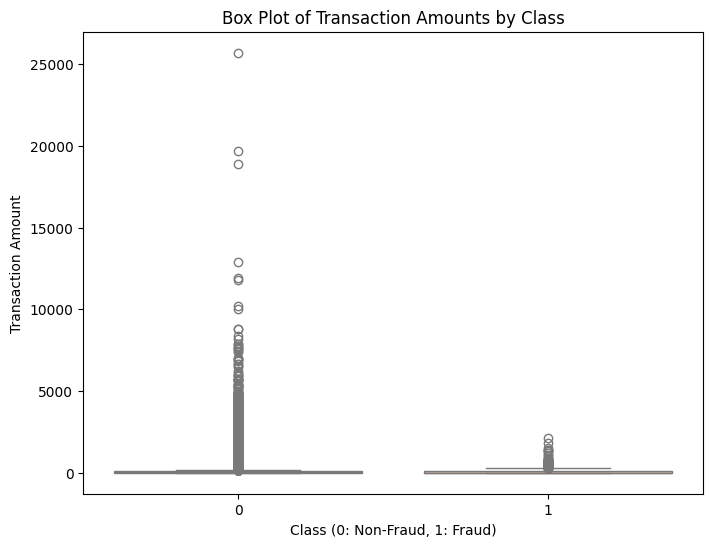

In [44]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=ccf_df, palette='coolwarm')
plt.title('Box Plot of Transaction Amounts by Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Transaction Amount')
plt.show()

**Description** <br><br>
The box plot visualizes the distribution of transaction amounts for two classes: non-fraudulent (Class 0) and fraudulent (Class 1) transactions. The central line in each box represents the median transaction amount, the edges of the box show the interquartile range (IQR), and the whiskers extend to the most extreme data points within 1.5 times the IQR. Outliers are plotted as individual points outside the whiskers.

**Insight** <br>
1. **Non-Fraudulent Transactions (Class 0):** The bulk of non-fraudulent transactions have low transaction amounts, indicated by the dense clustering of data near the lower end of the plot.There are numerous outliers with higher transaction amounts, extending well beyond the upper whisker of the box plot, with some reaching as high as 25,000. This indicates that while most non-fraudulent transactions involve small amounts, there are occasional high-value transactions, which is typical in real-world scenarios.

2. **Fraudulent Transactions (Class 1):** Fraudulent transactions generally have a lower range of transaction amounts compared to non-fraudulent transactions.
The distribution of fraudulent transactions is relatively compact, with fewer outliers than the non-fraudulent class.
This suggests that fraudsters tend to avoid very high-value transactions, possibly to avoid detection.

**Problem** <br><br>
The highly skewed nature of non-fraudulent transaction amounts (with a significant number of outliers) can make it challenging for standard models to distinguish between high-value non-fraudulent transactions and potential fraudulent transactions.
The overlap in transaction amounts between the two classes complicates the task of developing a precise fraud detection algorithm, as both classes share a range of values.

#### Feature Importance using RandomForest

Top features based on importance:
   Feature  Importance
17     V17    0.159579
12     V12    0.136299
14     V14    0.133185
16     V16    0.073350
10     V10    0.070759
11     V11    0.060359
9       V9    0.036541
18     V18    0.028497
7       V7    0.026338
4       V4    0.025977


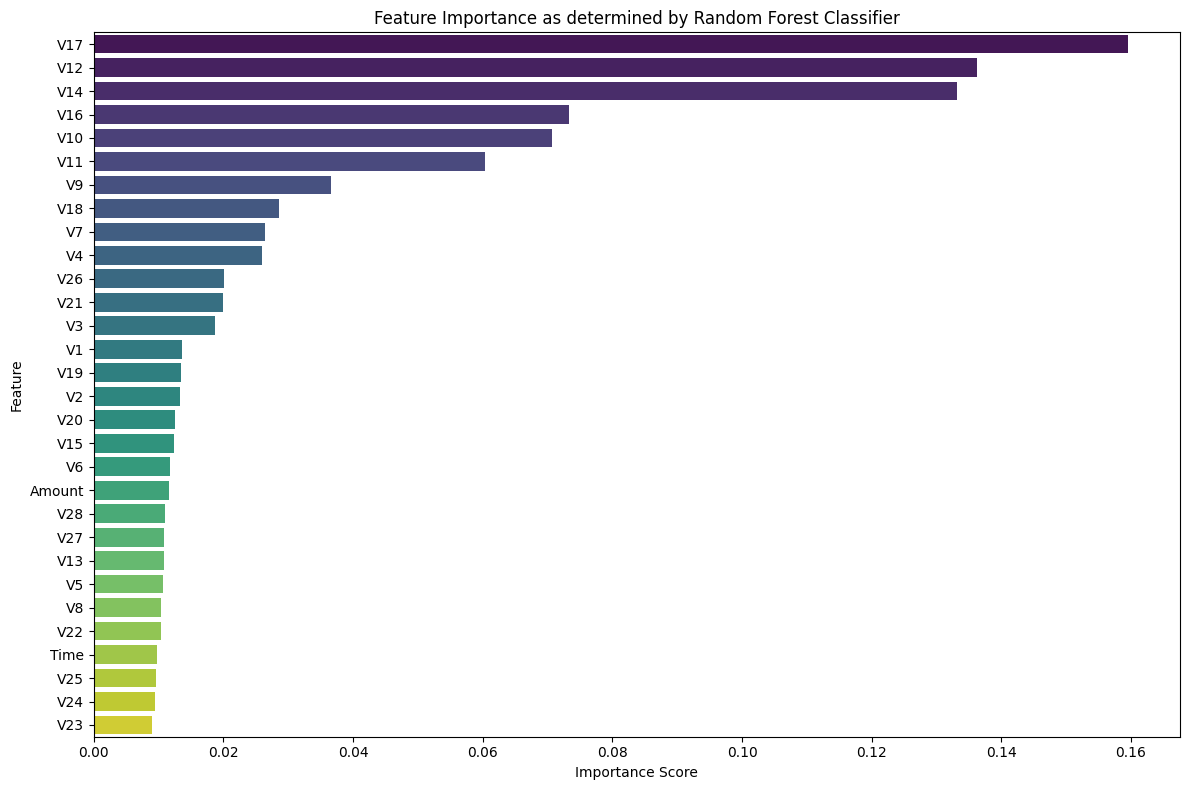

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data preprocessing
# Separate features (X) and target variable (y)
X = ccf_df.drop(columns=['Class'])
y = ccf_df['Class']

# Standardize the data (important for tree-based models to ensure fair importance calculation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets for feature importance calculation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier to determine feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top features based on importance:")
print(feature_importance_df.head(10))

# Visualize feature importance using a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance as determined by Random Forest Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Pair-plots of the top-5 important features with `Class`

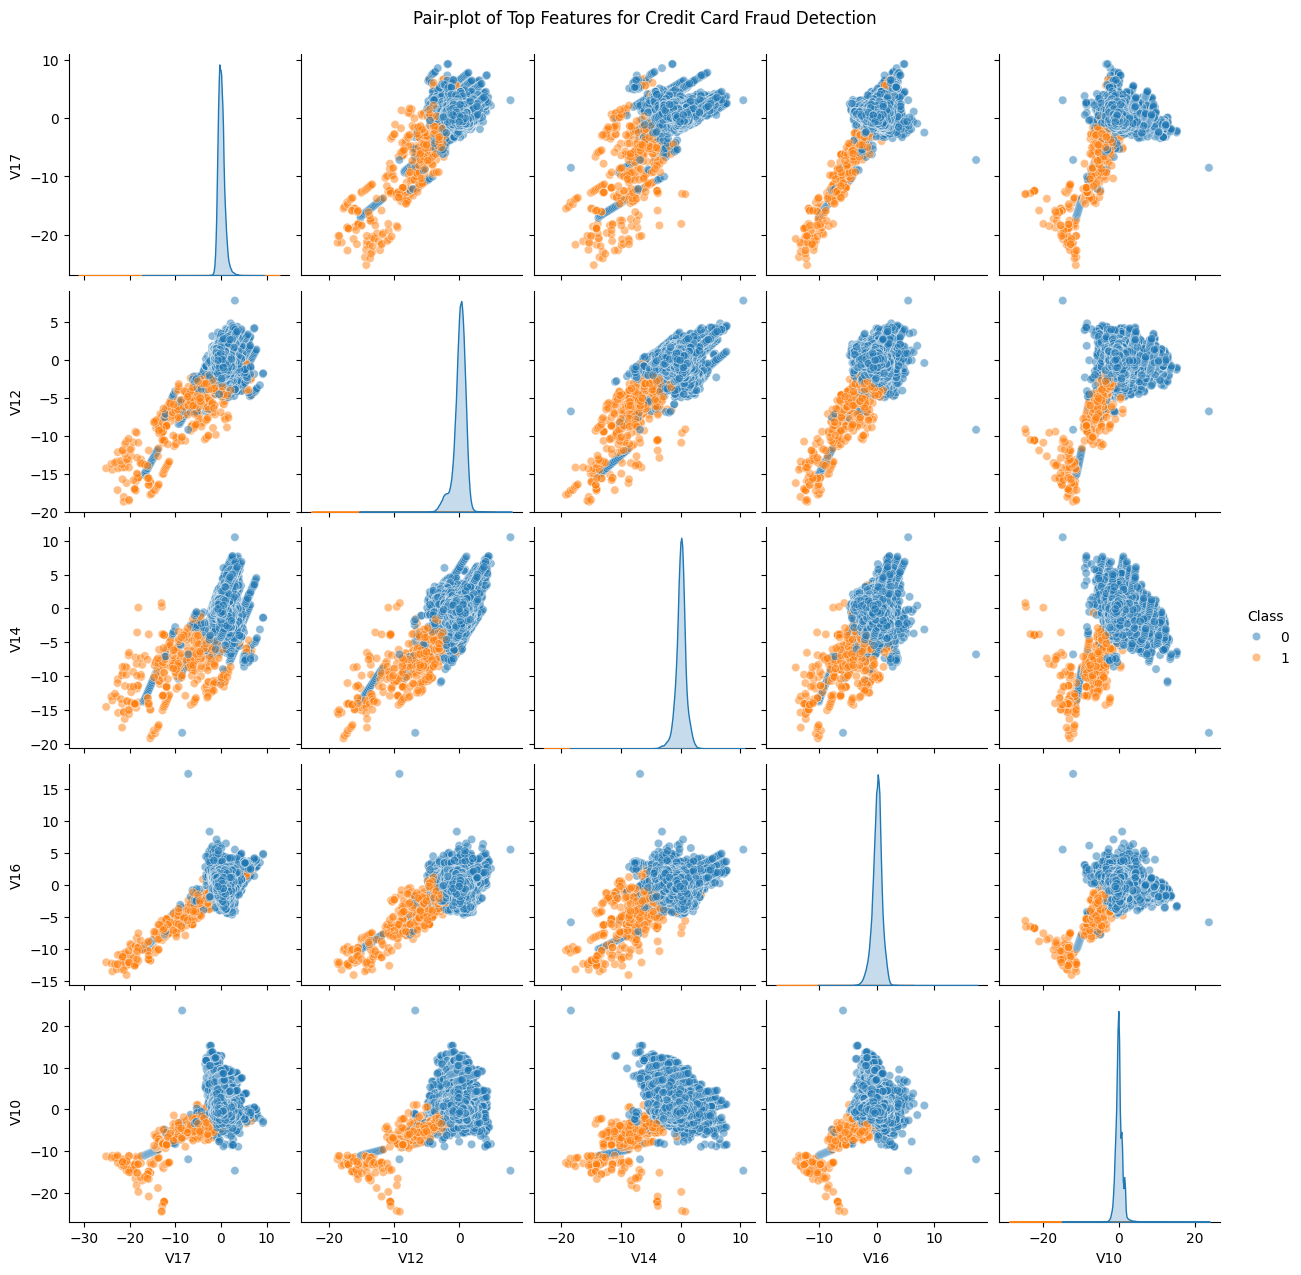

In [40]:
# Select the top 5 features based on importance
top_features = feature_importance_df['Feature'].head(5).tolist()

# Create a new DataFrame with only the top features and the target variable for visualization
pairplot_data = ccf_df[top_features + ['Class']]

# Visualize pair-plots using Seaborn
sns.pairplot(pairplot_data, hue='Class', plot_kws={'alpha': 0.5})
plt.suptitle('Pair-plot of Top Features for Credit Card Fraud Detection', y=1.02)
plt.show()

We Can See that V16 and V17 can distinguish the target easily. Same goes for V16 and V12.

#### Pair-plots of the bottom-5 important features with `Class`

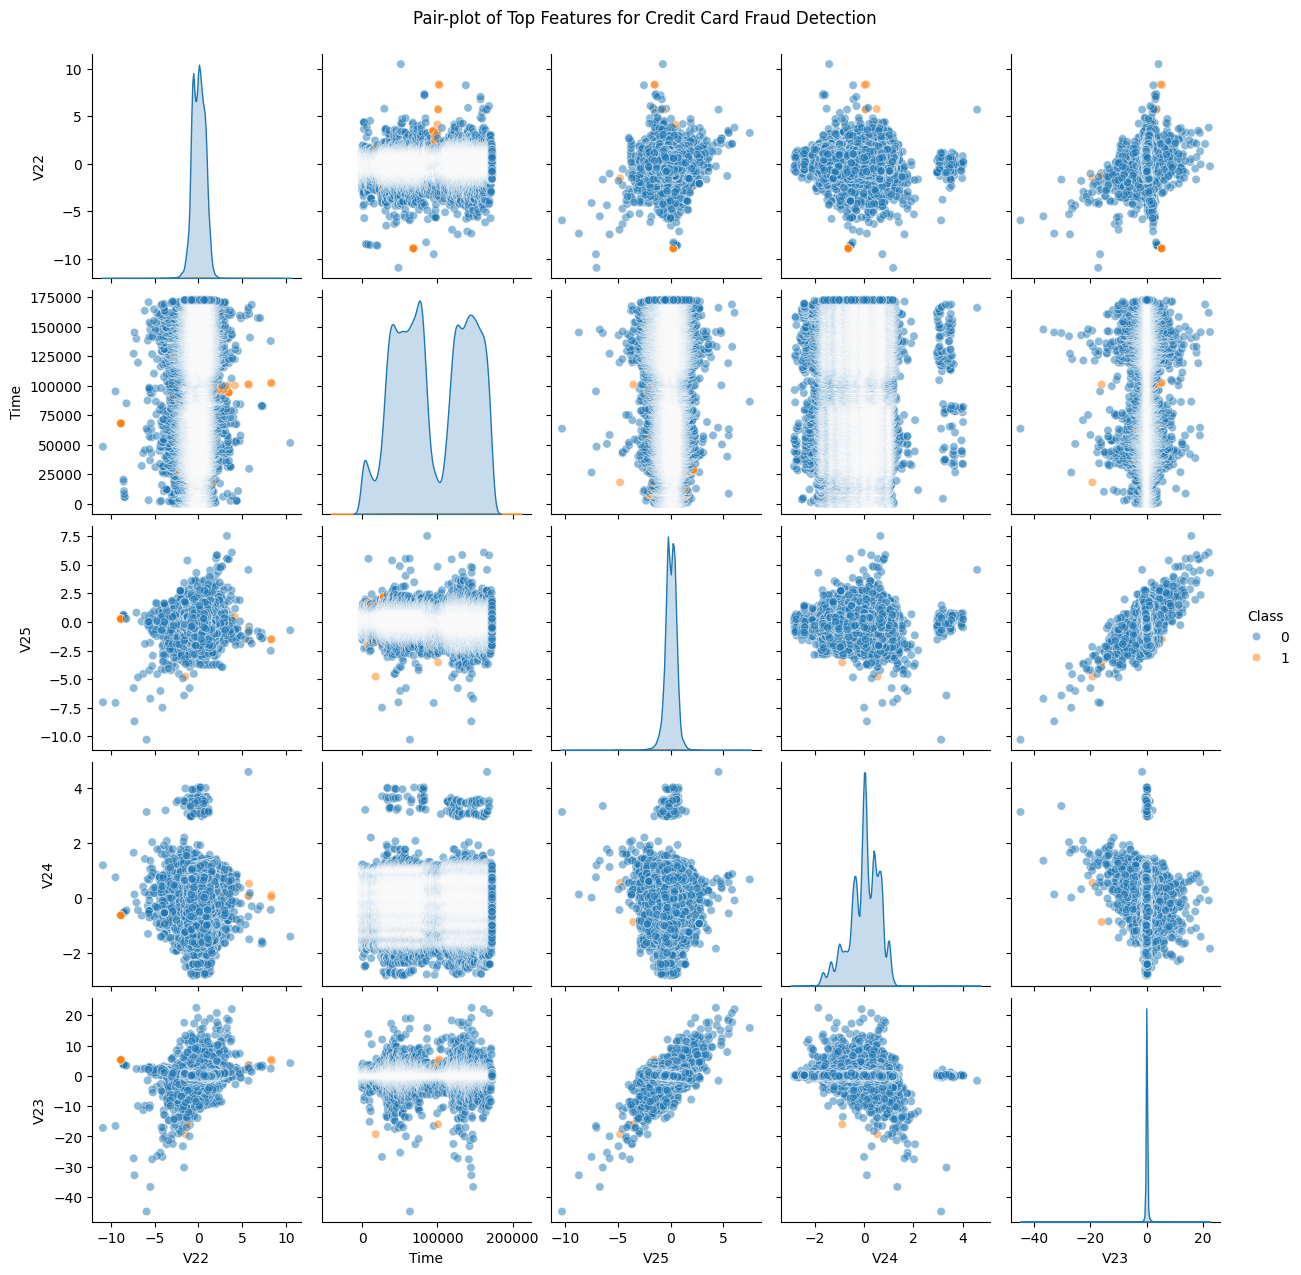

In [41]:
# Select the bottom 5 features based on importance
bottom_features = feature_importance_df['Feature'].tail(5).tolist()

# Create a new DataFrame with only the bottom features and the target variable for visualization
pairplot_data = ccf_df[bottom_features + ['Class']]

# Visualize pair-plots using Seaborn
sns.pairplot(pairplot_data, hue='Class', plot_kws={'alpha': 0.5})
plt.suptitle('Pair-plot of Bottom Features for Credit Card Fraud Detection', y=1.02)
plt.show()

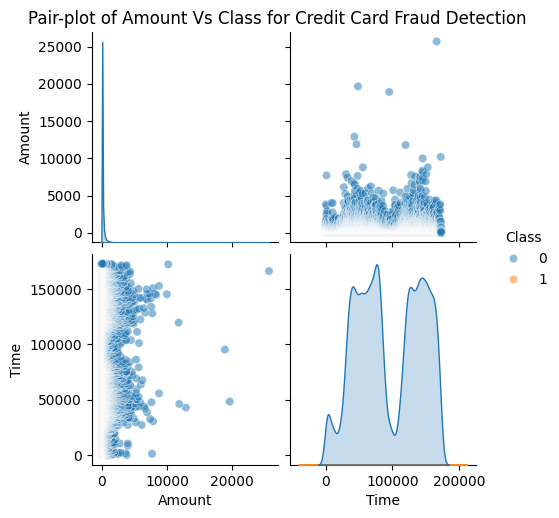

In [43]:
# Select Amount and Time features based on importance
amount_n_time = ['Amount', 'Time']

# Create a new DataFrame with only Amount and Time features and the target variable for visualization
pairplot_data = ccf_df[amount_n_time + ['Class']]

# Visualize pair-plots using Seaborn
sns.pairplot(pairplot_data, hue='Class', plot_kws={'alpha': 0.5})
plt.suptitle('Pair-plot of Amount Vs Class for Credit Card Fraud Detection', y=1.02)
plt.show()

Top features based on importance:
   Feature  Importance
17     V17    0.909307
14     V14    0.041216
27     V27    0.024314
10     V10    0.008521
7       V7    0.003277
8       V8    0.002724
21     V21    0.002004
1       V1    0.001973
20     V20    0.001488
23     V23    0.001327


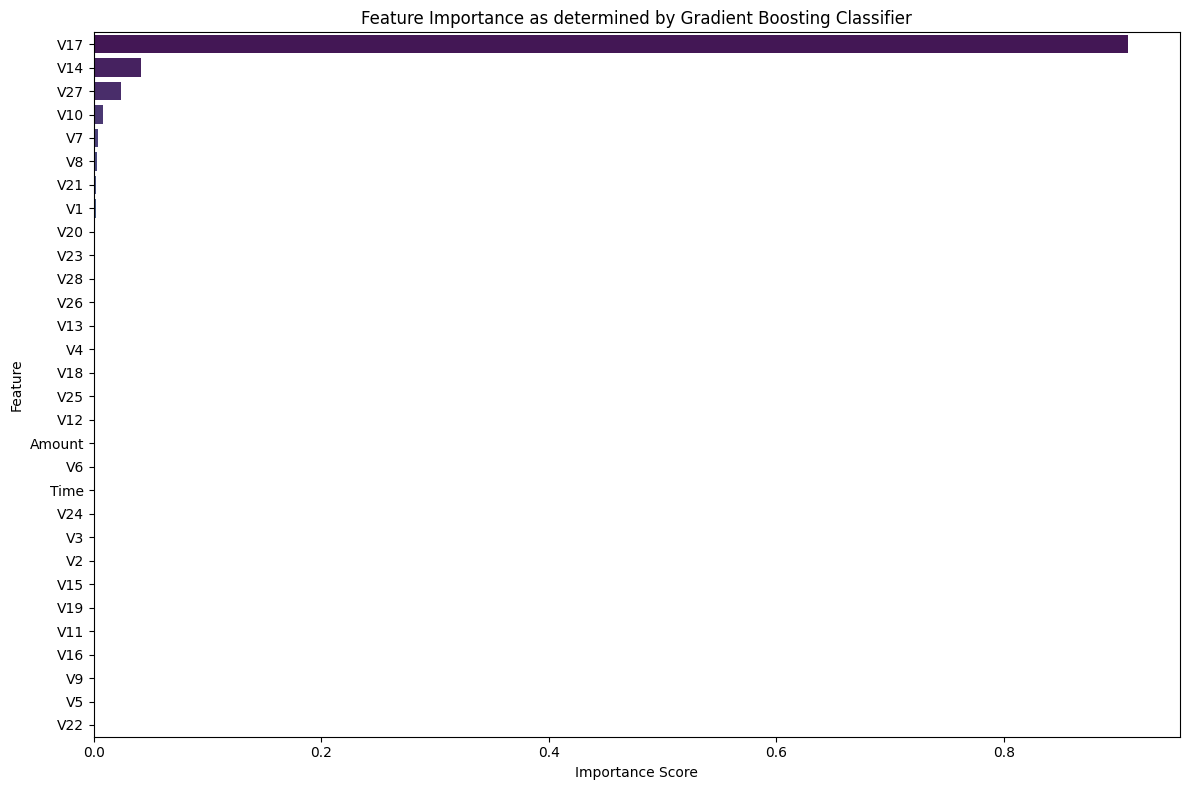

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data preprocessing
# Separate features (X) and target variable (y)
X = ccf_df.drop(columns=['Class'])
y = ccf_df['Class']

# Standardize the data (important for tree-based models to ensure fair importance calculation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets for feature importance calculation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier to determine feature importance
rf_model = GradientBoostingClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top features based on importance:")
print(feature_importance_df.head(10))

# Visualize feature importance using a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance as determined by Gradient Boosting Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

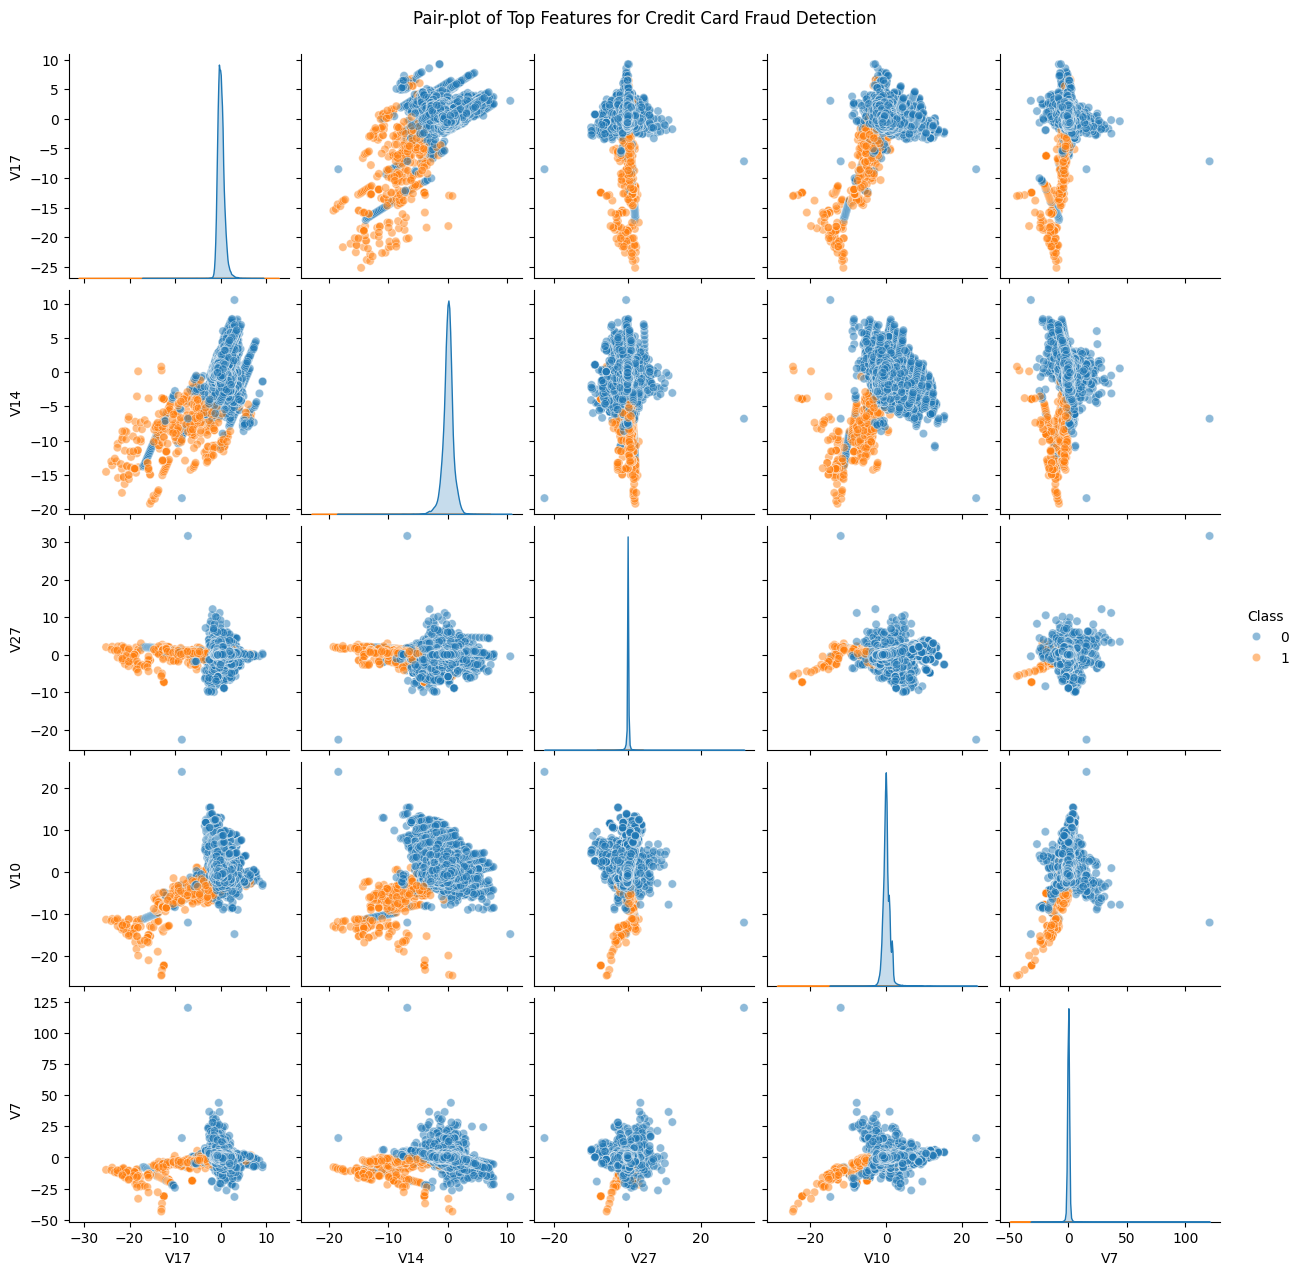

In [4]:
# Select the top 5 features based on importance
top_features = feature_importance_df['Feature'].head(5).tolist()

# Create a new DataFrame with only the top features and the target variable for visualization
pairplot_data = ccf_df[top_features + ['Class']]

# Visualize pair-plots using Seaborn
sns.pairplot(pairplot_data, hue='Class', plot_kws={'alpha': 0.5})
plt.suptitle('Pair-plot of Top Features for Credit Card Fraud Detection', y=1.02)
plt.show()

### Quantum EDA

In [53]:
# Data Preprocessing

# Selecting a subset of features for quantum embedding => {Selected based on feature importance bar plot}
selected_features = ['V17', 'V12', 'V14', 'V16', 'V10']

# Standardizing the 'Amount' and 'Time' features => mean=0, variance=1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ccf_df[selected_features] = scaler.fit_transform(ccf_df[selected_features])

X = ccf_df[selected_features].values[:100]  # Limit to 100 samples for visualization

# Quantum Feature Map to Embed data into Quantum State
feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=2, entanglement='linear')

# Function to create quantum circuits for each kdd_df point
quantum_circuits = []
for datapoint in X:
    circuit = feature_map.assign_parameters(datapoint)
    quantum_circuits.append(circuit)

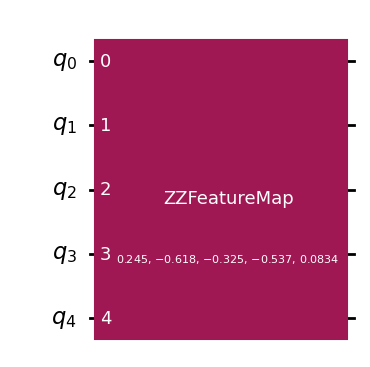

In [54]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

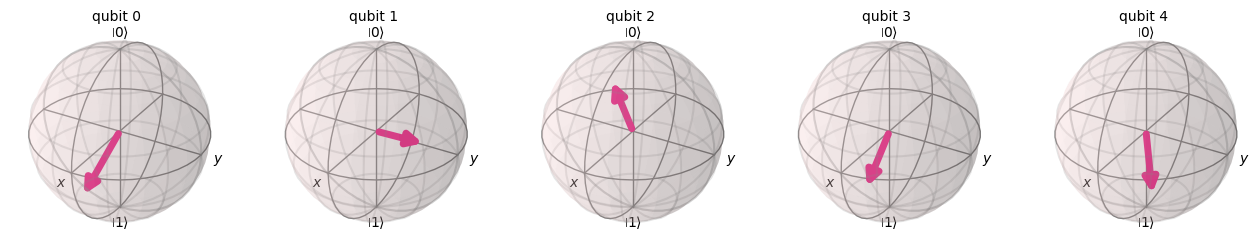

In [55]:
# Step 3: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first data point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

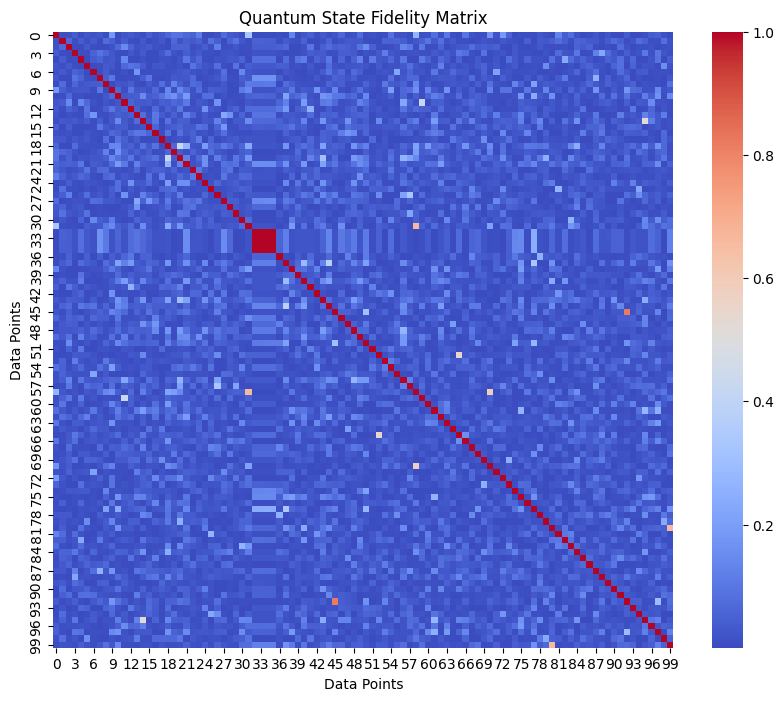

In [56]:
# Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(X), len(X)))

for i in range(len(X)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(X)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation
        
# Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

In [4]:
# Data Preprocessing

# Selecting a subset of features for quantum embedding => {Selected based on feature importance bar plot}
selected_features = ['V17', 'V12', 'V14', 'V16', 'V10']

# Standardizing the 'Amount' and 'Time' features => mean=0, variance=1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ccf_df[selected_features] = scaler.fit_transform(ccf_df[selected_features])

X = ccf_df[selected_features].values[:100]  # Limit to 100 samples for visualization

# Quantum Feature Map to Embed data into Quantum State
feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=5, entanglement='full')

# Function to create quantum circuits for each kdd_df point
quantum_circuits = []
for datapoint in X:
    circuit = feature_map.assign_parameters(datapoint)
    quantum_circuits.append(circuit)

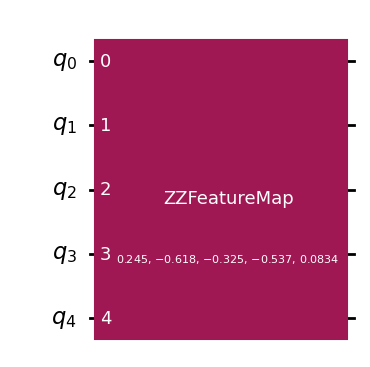

In [5]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

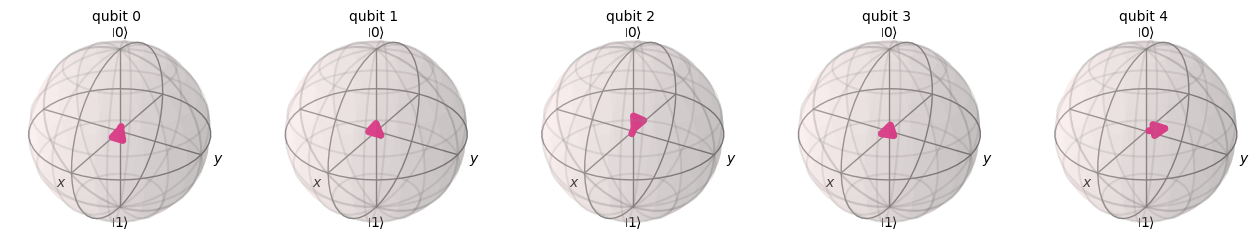

In [59]:
# Step 3: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first data point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

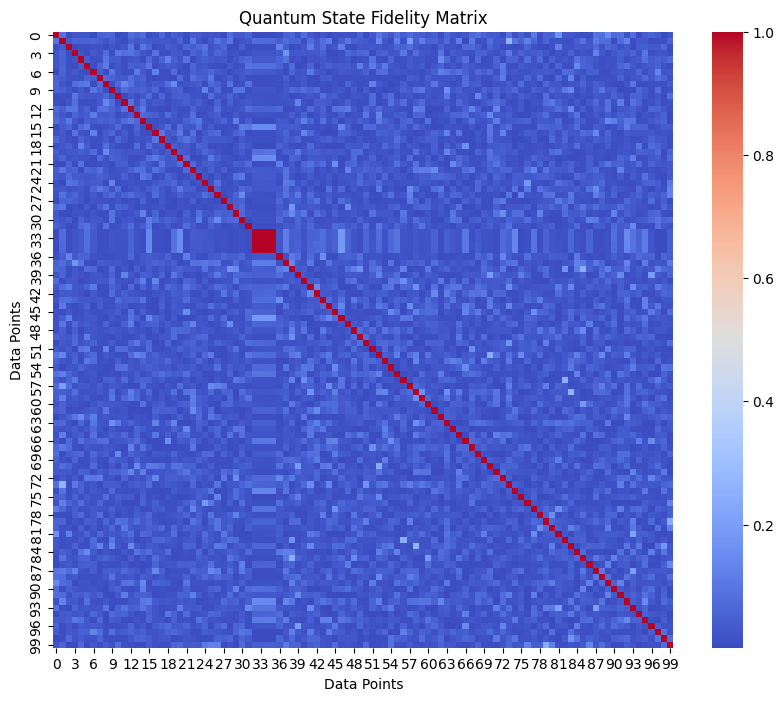

In [60]:
# Step 4: Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(X), len(X)))

for i in range(len(X)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(X)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation
        
# Step 5: Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

#### Classical Classification Models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

In [7]:
selected_features = ['V17', 'V12', 'V14', 'V16', 'V10', 'Class']
X = ccf_df[selected_features].drop('Class', axis=1)
y = ccf_df['Class']

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# Addressing data imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [10]:
# Feature scaling (Standardization)
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

In [4]:
def plot_cm(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def plot_report(report):
    report_df = pd.DataFrame(report).transpose()
    print(report_df.head(10))
    tick_labels = report_df.index

    plt.figure(figsize=(10, 6))
    report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', rot=0, ax=plt.gca())
    plt.title('Classification Report Metrics')
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.ylim(0, 1)
    plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=45)
    plt.legend(title='Metrics', loc='upper left')
    plt.show()


def plot_roc_auc(y_test, y_proba):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Visualizing Feature Importance for Tree-based Models
def visualize_feature_importance(models):
    for model_name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            plt.figure(figsize=(8, 6))
            plt.barh(selected_features[:-1], model.feature_importances_)
            plt.title(f'Feature Importance in {model_name}')
            plt.xlabel('Importance Score')
            plt.ylabel('Features')
            plt.show()

### Evaluation Metrics for the testing result

1. **ROC AUC Score**:
   - **Definition**: The ROC AUC score (Receiver Operating Characteristic Area Under the Curve) measures the ability of the model to distinguish between classes. It ranges from 0 to 1, where 1 indicates perfect classification and 0.5 indicates no discriminative power (random guessing).
   - **Interpretation**: A higher ROC AUC score indicates better performance.

2. **Precision**:
   - **Definition**: Precision (also called Positive Predictive Value) measures the proportion of true positive predictions among all positive predictions made by the model.
   - **Formula**: 
     $$
     \text{Precision} = \frac{TP}{TP + FP}
     $$
   - **Interpretation**: High precision means that when the model predicts fraud, it is likely correct.

3. **Recall**:
   - **Definition**: Recall (also called Sensitivity or True Positive Rate) measures the proportion of true positive predictions among all actual positive instances.
   - **Formula**: 
     $$
     \text{Recall} = \frac{TP}{TP + FN}
     $$
   - **Interpretation**: High recall means that the model captures most of the actual fraud cases.

4. **F1-Score**:
   - **Definition**: The F1-score is the harmonic mean of precision and recall, balancing the trade-off between the two metrics.
   - **Formula**: 
     $$
     F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
     $$
   - **Interpretation**: The F1-score provides a single metric for model performance, especially useful when dealing with imbalanced datasets.

5. **Support**:
   - **Definition**: Support is the number of actual occurrences of the class in the specified dataset.
   - **Interpretation**: It provides context for interpreting precision and recall, as a low support can result in misleading metrics.

6. **Classes (0 and 1)**:
   - These refer to the classes in the binary classification problem, where 0 typically represents the negative class (non-fraud) and 1 represents the positive class (fraud).

7. **Accuracy**:
   - **Definition**: Accuracy is the proportion of true results (both true positives and true negatives) among the total number of cases examined.
   - **Formula**: 
     $$
     \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
     $$
   - **Interpretation**: Accuracy can be misleading in imbalanced datasets, as it does not account for the distribution of classes.

8. **Macro Average**:
   - **Definition**: The macro average calculates the metrics (precision, recall, F1-score) for each class independently and then takes the average.
   - **Interpretation**: It treats all classes equally, making it useful for imbalanced datasets.

9. **Weighted Average**:
   - **Definition**: The weighted average calculates the metrics for each class independently and then averages them, weighting by the number of instances in each class.
   - **Interpretation**: This gives more importance to classes with higher support, making it more representative of the overall performance.

In [12]:
# Build classification models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}


Model: Logistic Regression


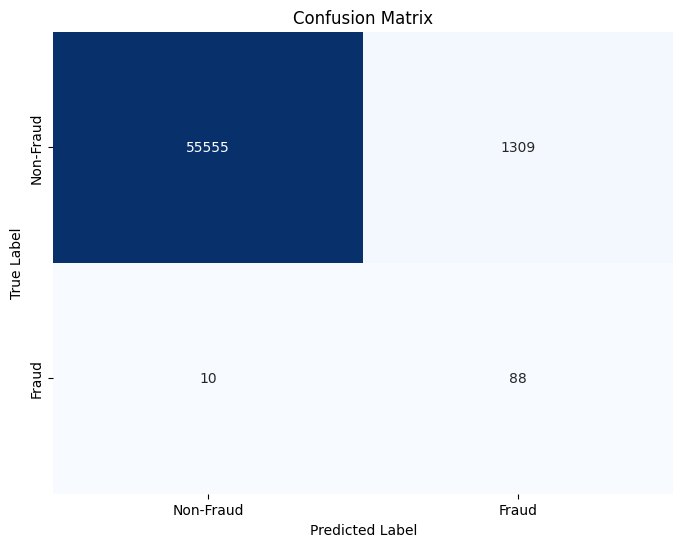

              precision    recall  f1-score       support
0              0.999820  0.976980  0.988268  56864.000000
1              0.062992  0.897959  0.117726     98.000000
accuracy       0.976844  0.976844  0.976844      0.976844
macro avg      0.531406  0.937470  0.552997  56962.000000
weighted avg   0.998208  0.976844  0.986770  56962.000000


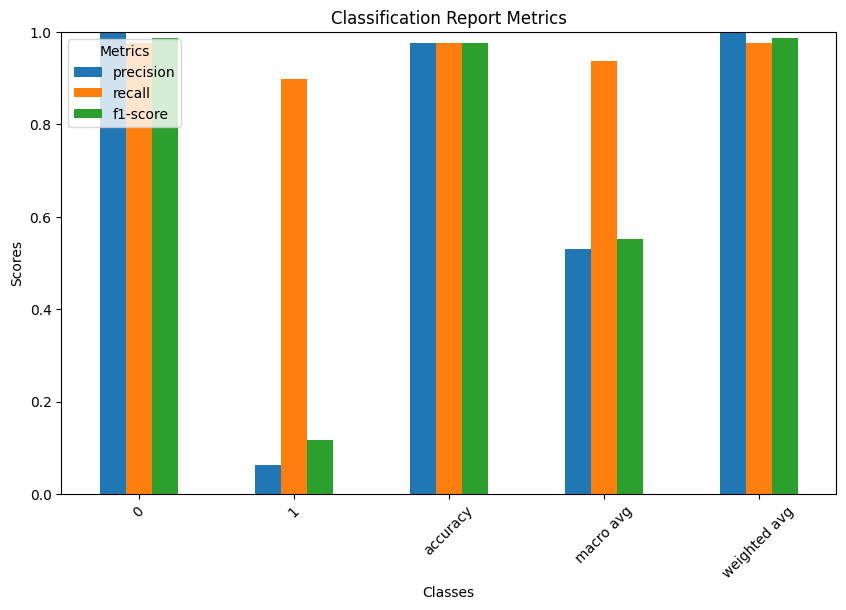

ROC AUC Score: 0.9683539601828351


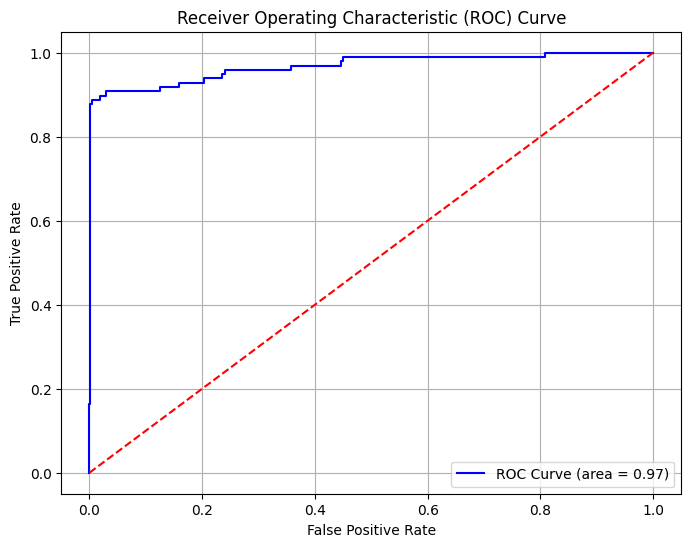


Model: Random Forest


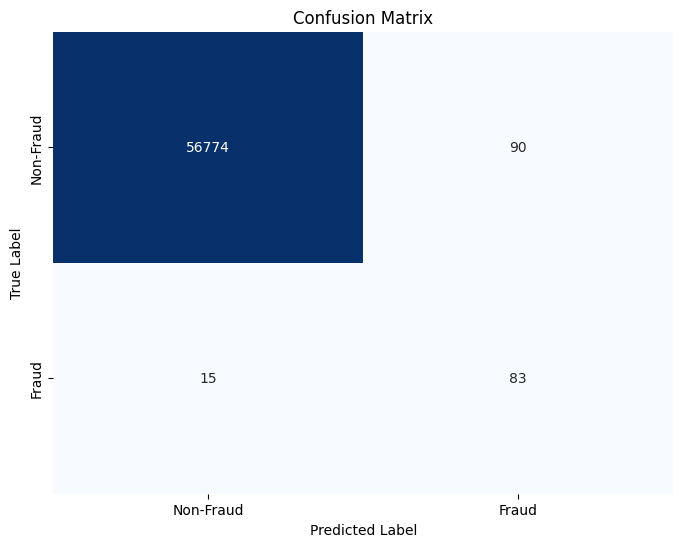

              precision    recall  f1-score       support
0              0.999736  0.998417  0.999076  56864.000000
1              0.479769  0.846939  0.612546     98.000000
accuracy       0.998157  0.998157  0.998157      0.998157
macro avg      0.739752  0.922678  0.805811  56962.000000
weighted avg   0.998841  0.998157  0.998411  56962.000000


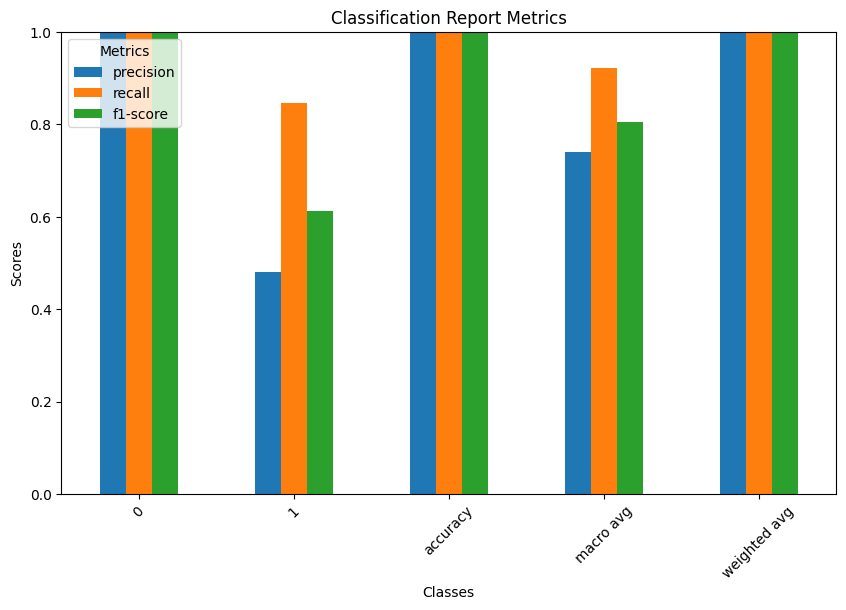

ROC AUC Score: 0.9602389123206965


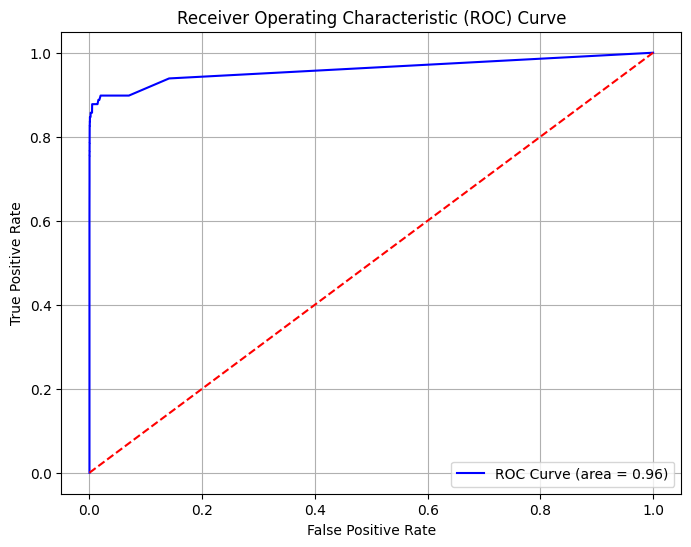


Model: Gradient Boosting


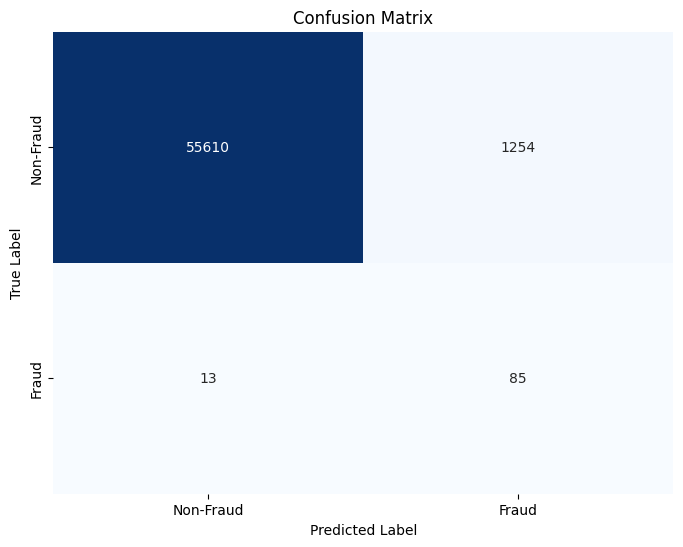

              precision    recall  f1-score       support
0              0.999766  0.977947  0.988736  56864.000000
1              0.063480  0.867347  0.118302     98.000000
accuracy       0.977757  0.977757  0.977757      0.977757
macro avg      0.531623  0.922647  0.553519  56962.000000
weighted avg   0.998155  0.977757  0.987239  56962.000000


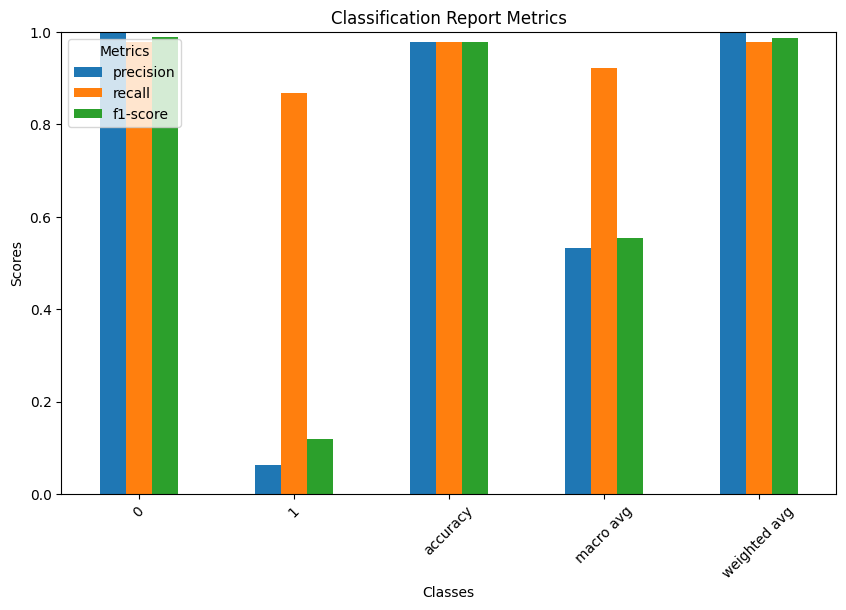

ROC AUC Score: 0.9543241554500247


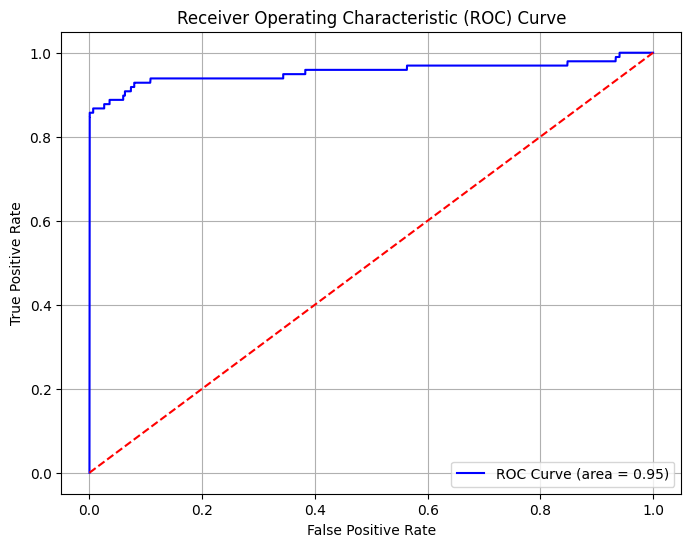

In [27]:
# Train and evaluate each model
for model_name, model in models.items():
    # Training
    model.fit(X_resampled, y_resampled)

    # Making predictions on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    print(f'\nModel: {model_name}')
    plot_cm(confusion_matrix(y_test, y_pred))
    plot_report(classification_report(y_test, y_pred, output_dict=True))
    print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
    plot_roc_auc(y_test, y_proba)

In [ ]:
visualize_feature_importance(models)

### Explanation of the Findings:

1.  **Precision** measures the accuracy of the positive predictions. A higher precision for the Random Forest means it makes fewer false positive predictions (fraud flagged when it's not fraud).
    
2.  **ROC-AUC Score** measures how well the model distinguishes between the positive (fraud) and negative (non-fraud) classes across various threshold values. A higher ROC-AUC indicates a better-performing model in distinguishing between classes, with the Logistic Regressor showing the best score.
    
3.  **ROC Curves** being almost identical means that all three models have similar true positive and false positive rates across different thresholds.

### Next Steps 
Reducing false positives (actual non-fraud predicted as fraud) is critical to improve precision.

1.  **Increase the Decision Threshold:** Increase the classification threshold to increase the sensitivity of the models.
2.  **Class Weight Adjustment:** Increase the weight of the minority class (fraud) in the models to prioritize correctly identifying fraudulent cases.
3.  **Ensemble Techniques:** Combine models to take advantage of their individual strengths.

### Increasing Threshold...


Model: Logistic Regression


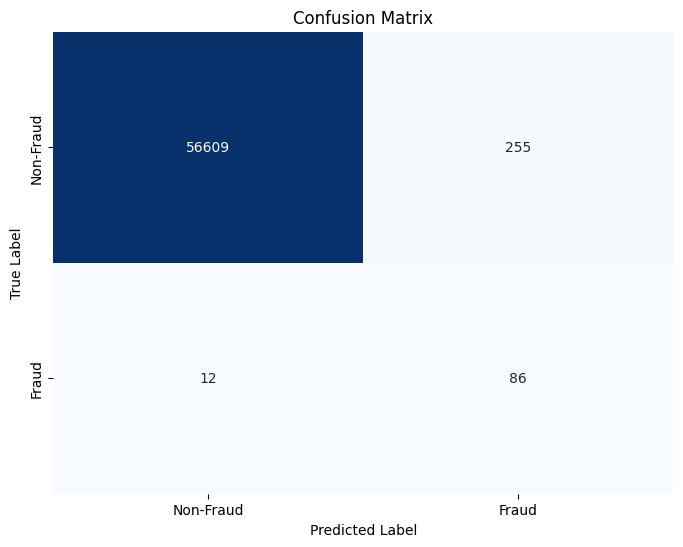

              precision    recall  f1-score       support
0              0.999788  0.995516  0.997647  56864.000000
1              0.252199  0.877551  0.391800     98.000000
accuracy       0.995313  0.995313  0.995313      0.995313
macro avg      0.625994  0.936533  0.694723  56962.000000
weighted avg   0.998502  0.995313  0.996605  56962.000000


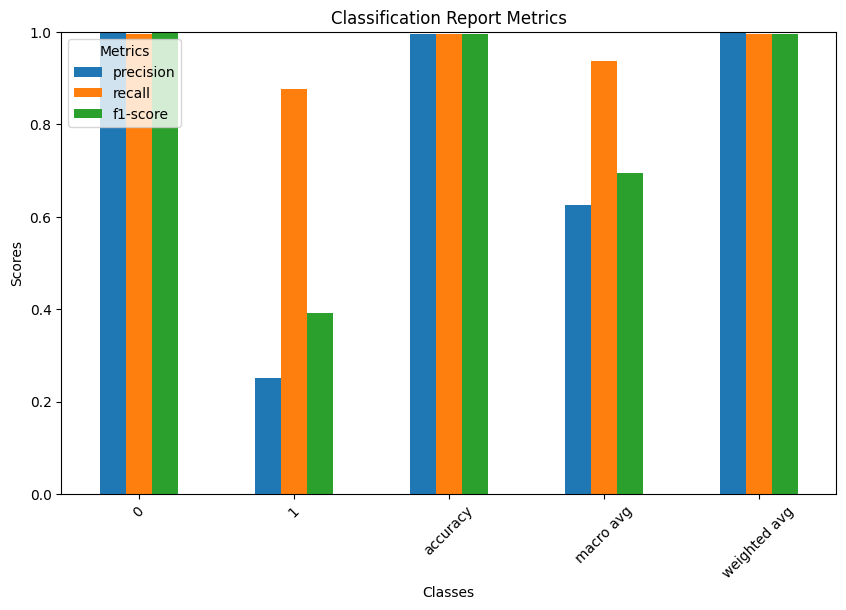

ROC AUC Score: 0.96815351773799


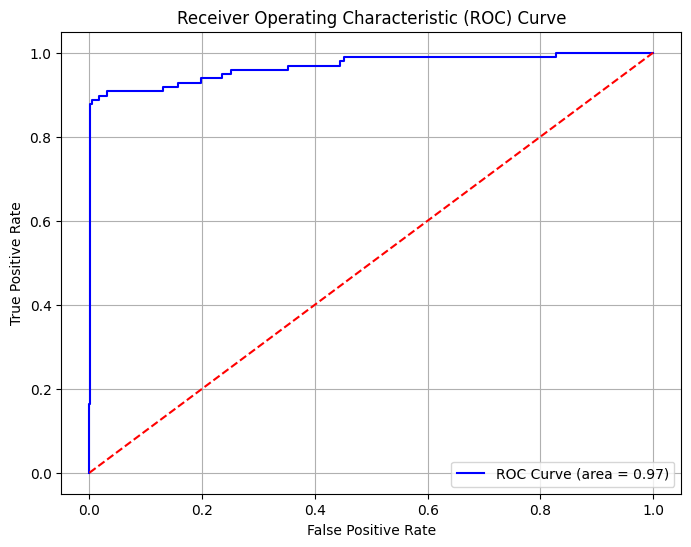


Model: Random Forest


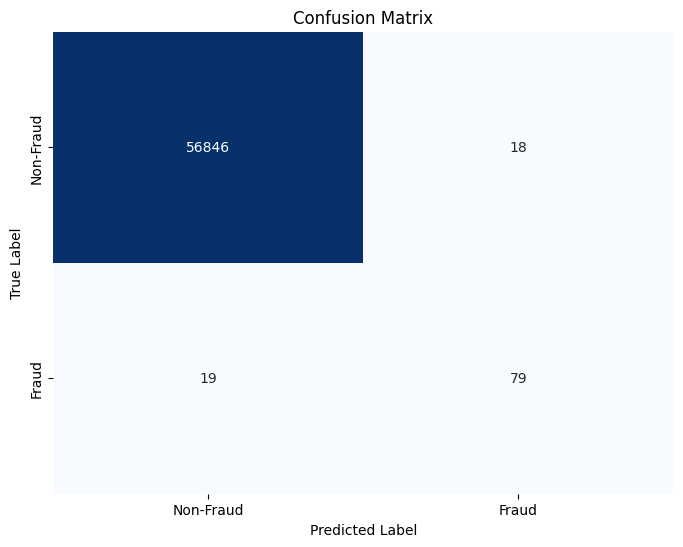

              precision    recall  f1-score      support
0              0.999666  0.999683  0.999675  56864.00000
1              0.814433  0.806122  0.810256     98.00000
accuracy       0.999350  0.999350  0.999350      0.99935
macro avg      0.907049  0.902903  0.904966  56962.00000
weighted avg   0.999347  0.999350  0.999349  56962.00000


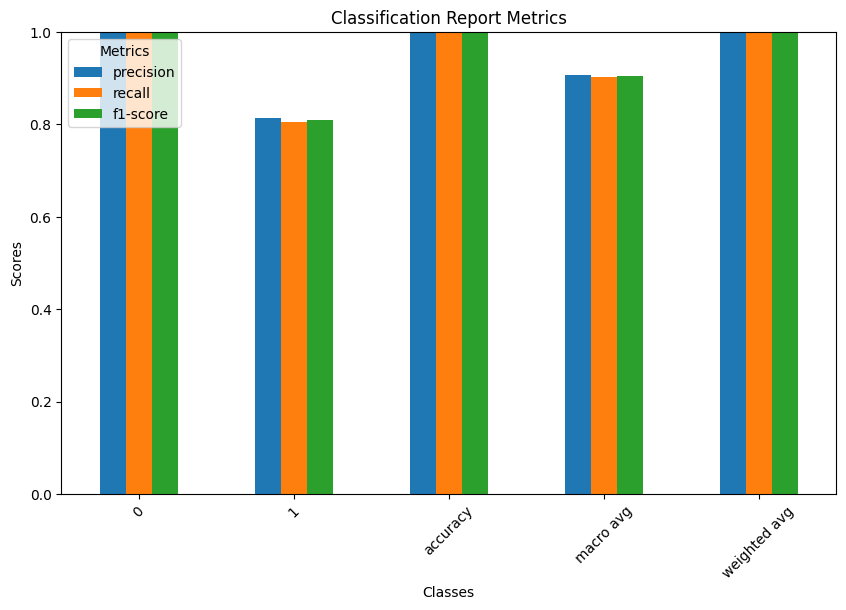

ROC AUC Score: 0.9556286463656931


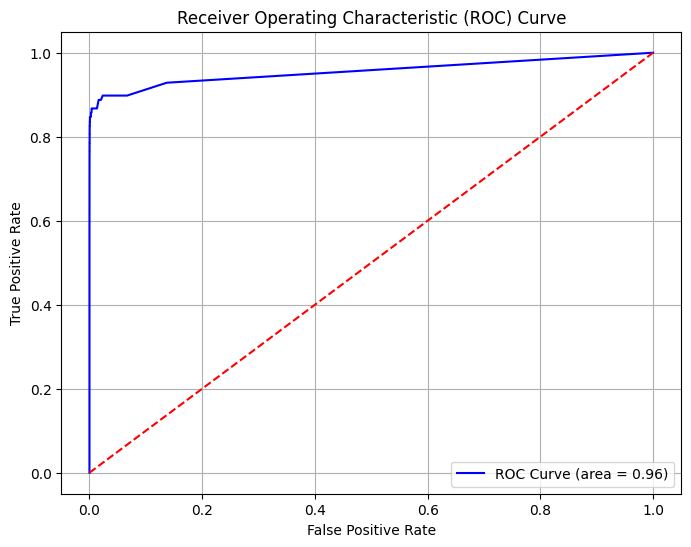


Model: Gradient Boosting


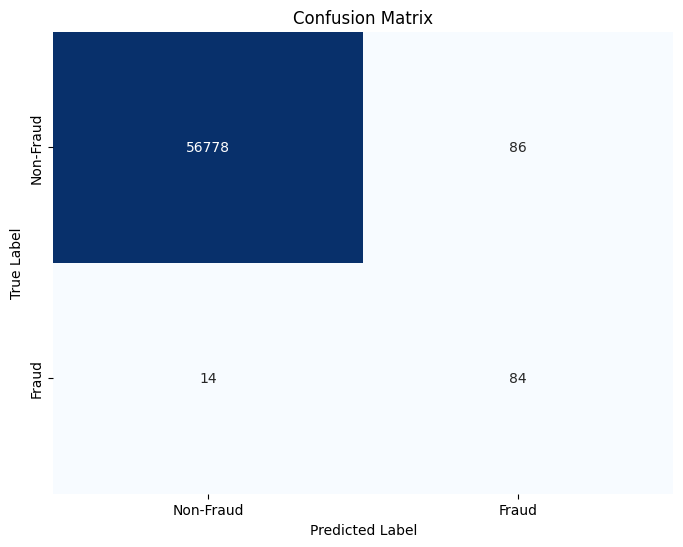

              precision    recall  f1-score       support
0              0.999753  0.998488  0.999120  56864.000000
1              0.494118  0.857143  0.626866     98.000000
accuracy       0.998244  0.998244  0.998244      0.998244
macro avg      0.746936  0.927815  0.812993  56962.000000
weighted avg   0.998884  0.998244  0.998480  56962.000000


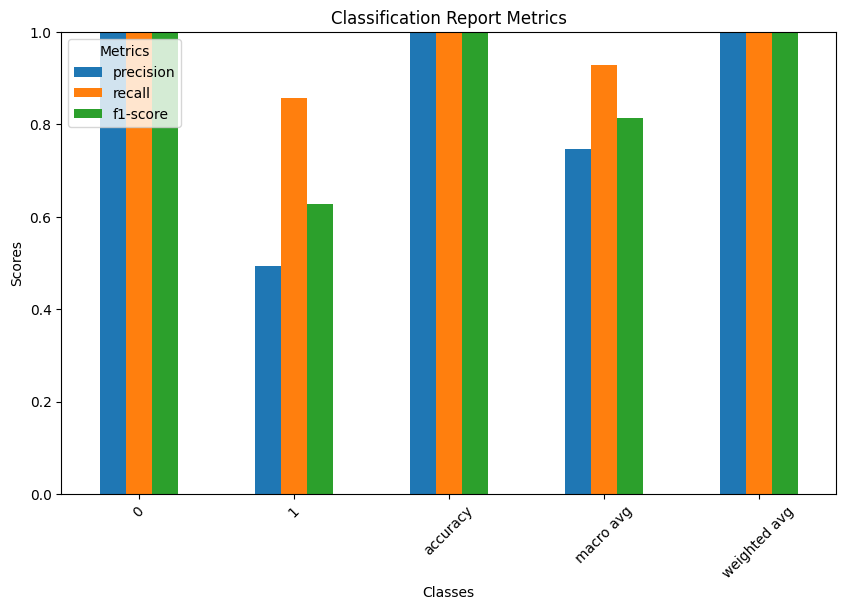

ROC AUC Score: 0.961101604400905


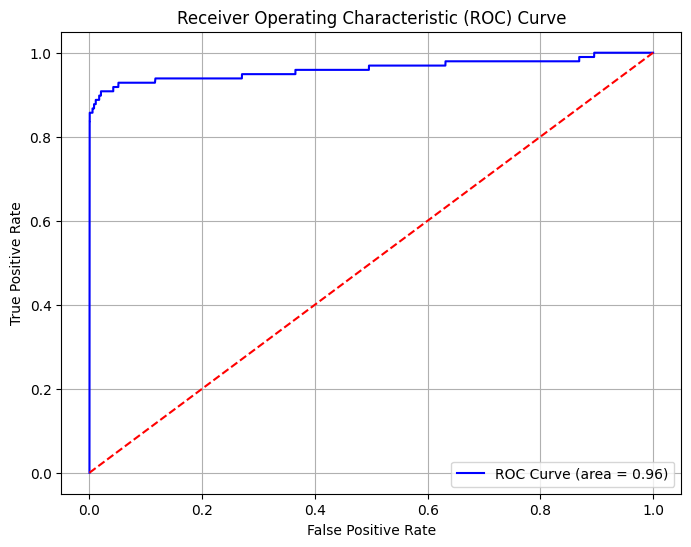

In [19]:
# Train and evaluate each model with increased theshold
new_probability_threshold = 0.83
for model_name, model in models.items():
    # Training
    model.fit(X_resampled, y_resampled)

    # Making predictions on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_new_threshold = (y_proba >= new_probability_threshold).astype(int)

    # Evaluation metrics
    print(f'\nModel: {model_name}')
    plot_cm(confusion_matrix(y_test, y_pred_new_threshold))
    plot_report(classification_report(y_test, y_pred_new_threshold, output_dict=True))
    print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
    plot_roc_auc(y_test, y_proba)

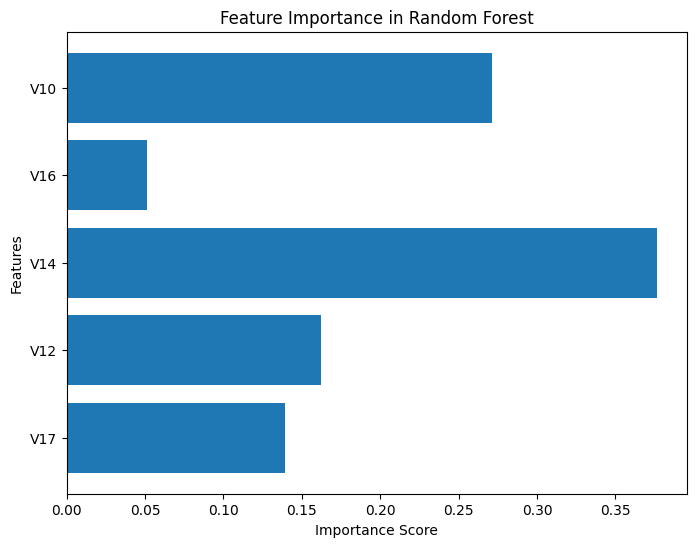

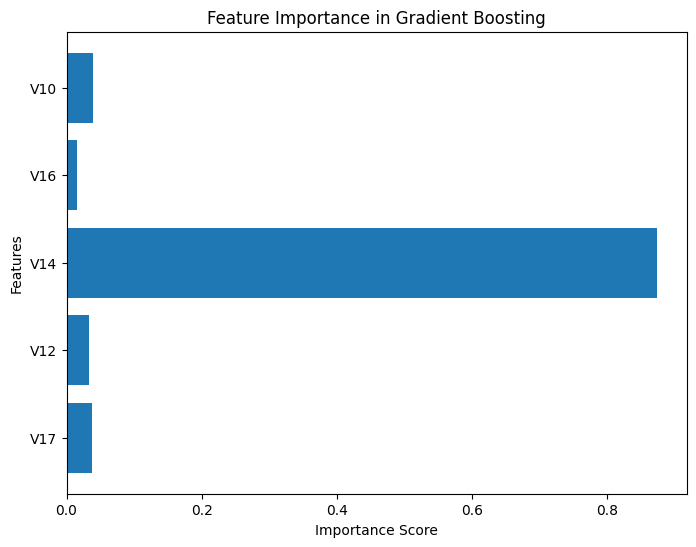

In [18]:
visualize_feature_importance(models)

### Insights from Adjusting the Decision Threshold

- **Threshold Adjustment**:
  - Setting the decision threshold to `> 0.5`, means to make the models classify a case as `fraud` only if the predicted probability exceeds the set threshold value.
  - This approach led to slight and proportional improvements in all three models.

#### Why the Improvement Happens
- **All Three Models**:
  - By increasing the threshold from the default (usually `0.5`) to `> 0.5`, you're making the models more conservative in predicting the positive class (`fraud`). This reduces false positives but can potentially increase false negatives.
  - In your case, it seems that raising the threshold led to a balanced reduction in both types of errors, indicating that your models were slightly over-predicting fraud cases at the default threshold.

#### Takeaway
- Adjusting the threshold can be a straightforward way to control the trade-off between **precision** (minimizing false positives) and **recall** (minimizing false negatives).
- Since all three models responded proportionally to this change, it suggests that they have similar sensitivity to the threshold setting, aligning their decision boundaries more effectively.

### Cost-sensitive learning...

{0: 10, 1: 1}
[10 10 10 ...  1  1  1]

Model: Logistic Regression


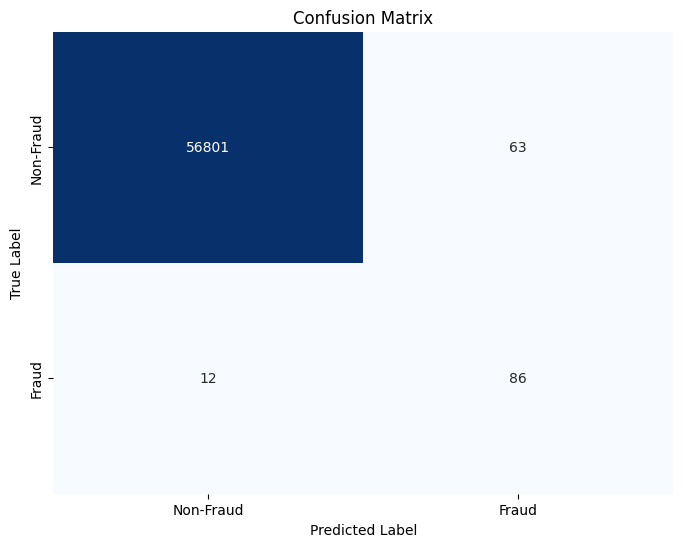

              precision    recall  f1-score       support
0              0.999789  0.998892  0.999340  56864.000000
1              0.577181  0.877551  0.696356     98.000000
accuracy       0.998683  0.998683  0.998683      0.998683
macro avg      0.788485  0.938222  0.847848  56962.000000
weighted avg   0.999062  0.998683  0.998819  56962.000000


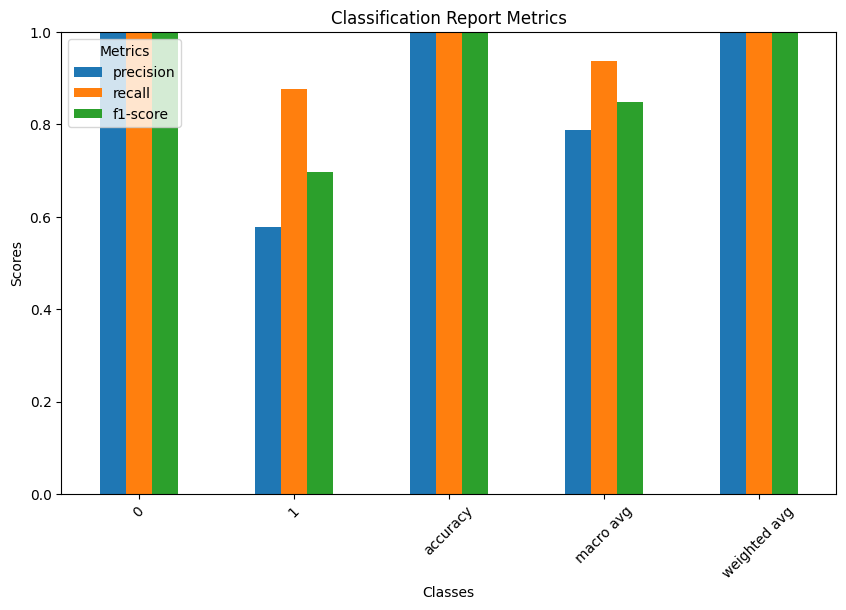

ROC AUC Score: 0.9658241145360789


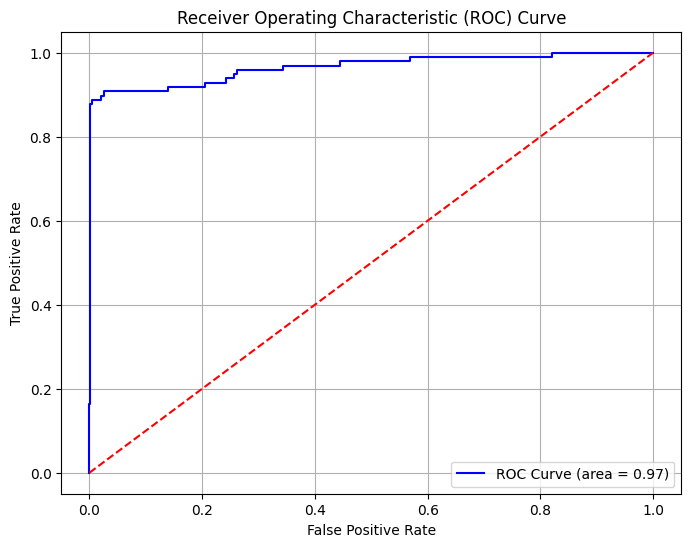


Model: Random Forest


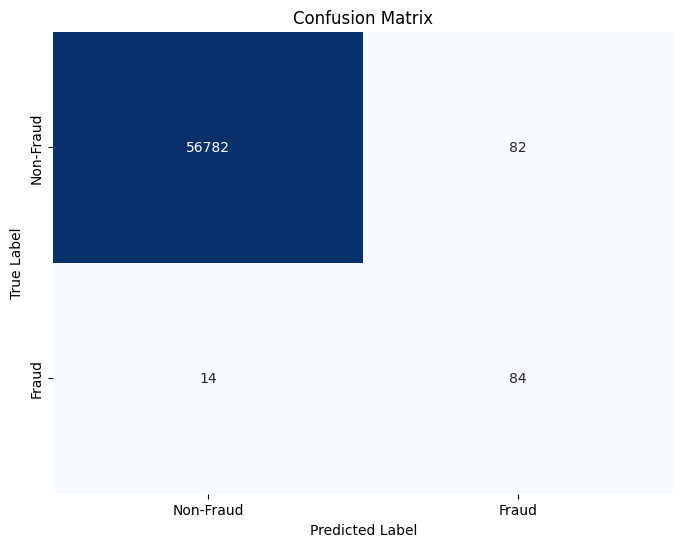

              precision    recall  f1-score       support
0              0.999754  0.998558  0.999155  56864.000000
1              0.506024  0.857143  0.636364     98.000000
accuracy       0.998315  0.998315  0.998315      0.998315
macro avg      0.752889  0.927850  0.817760  56962.000000
weighted avg   0.998904  0.998315  0.998531  56962.000000


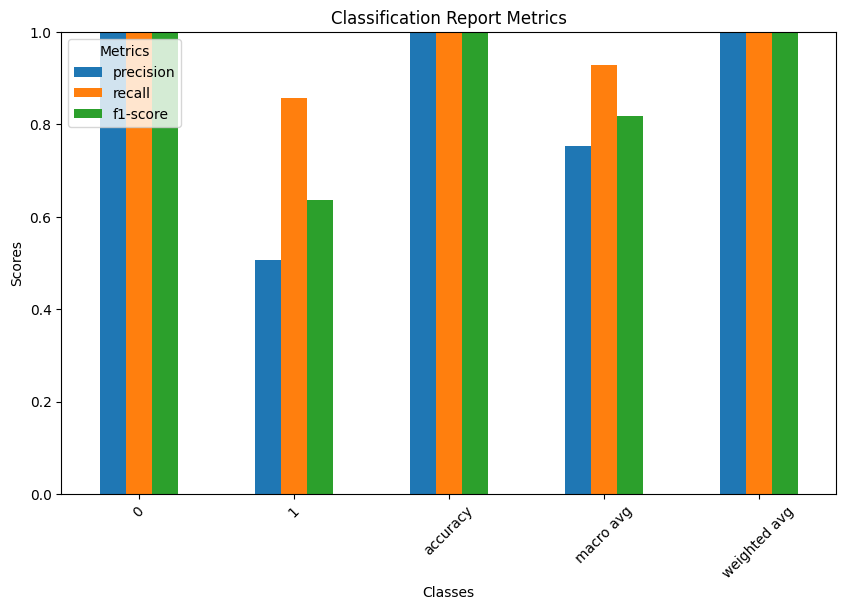

ROC AUC Score: 0.9571597790072698


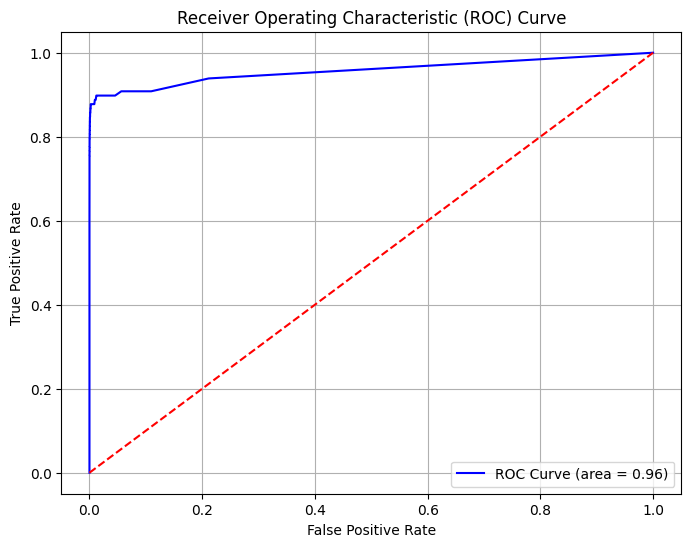


Model: Gradient Boosting


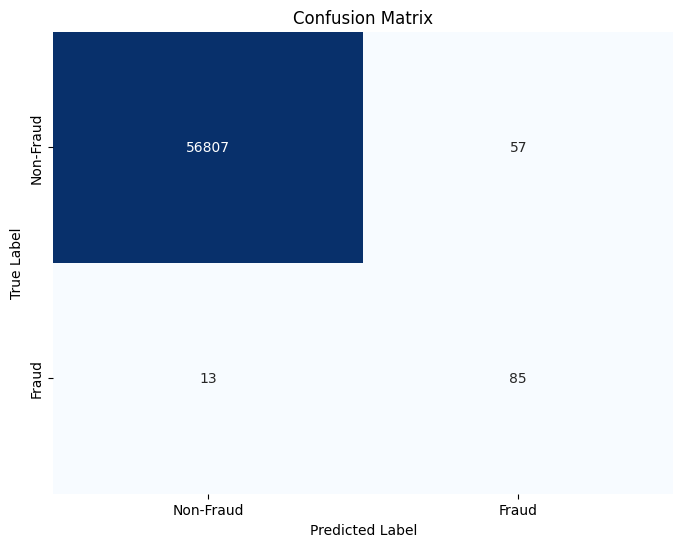

              precision    recall  f1-score       support
0              0.999771  0.998998  0.999384  56864.000000
1              0.598592  0.867347  0.708333     98.000000
accuracy       0.998771  0.998771  0.998771      0.998771
macro avg      0.799181  0.933172  0.853859  56962.000000
weighted avg   0.999081  0.998771  0.998884  56962.000000


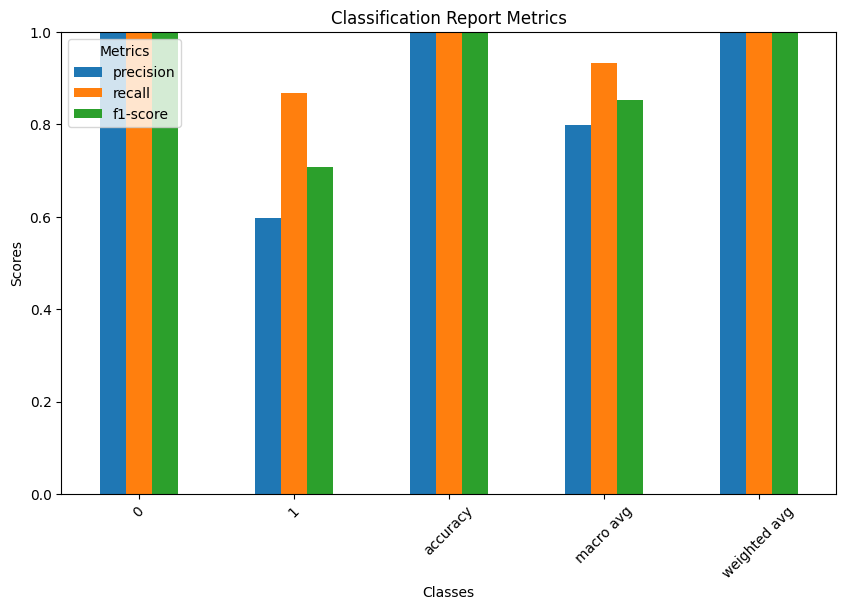

ROC AUC Score: 0.9619439292317941


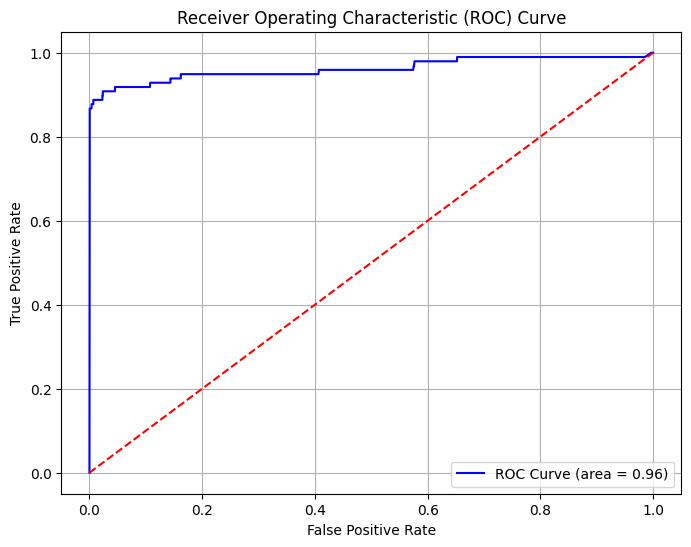

In [50]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)

# Get class weights based on the training data
class_weights = {0: 10, 1: 1}
sample_weights = np.array([class_weights[int(y)] for y in y_resampled])

# Train and evaluate each model with cost(weight)-sensitive learning
for model_name, model in models.items():
    # Training
    model.fit(X_resampled, y_resampled, sample_weight=sample_weights)

    # Making predictions on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Evaluation metrics
    print(f'\nModel: {model_name}')
    plot_cm(confusion_matrix(y_test, y_pred))
    plot_report(classification_report(y_test, y_pred, output_dict=True))
    print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
    plot_roc_auc(y_test, y_proba)

In [ ]:
visualize_feature_importance(models)

### Insights from Adjusting Class Weights

- **Class Weights Adjustment**: 
  - You assigned weights of `{0: 10, 1: 1}`, which means you increased the importance of the negative class (`non-fraud`) by a factor of 10 compared to the positive class (`fraud`).
  - This adjustment primarily benefits the **Logistic Regression** and **Gradient Boosting** models, while the **Random Forest** model only shows a slight improvement.

#### Why the Improvement Happens
- **Logistic Regression and Gradient Boosting**:
  - These models tend to perform well when the cost of misclassification is explicitly defined using class weights.
  - Logistic Regression is a linear model, so emphasizing the minority class directly influences its decision boundary.
  - Gradient Boosting, being an iterative model that builds trees sequentially, adapts to class weights effectively by learning from the misclassified instances. This results in a more refined decision-making process.
  
- **Random Forest**:
  - Random Forest is less sensitive to class weights compared to other models because of its ensemble nature (it builds multiple decision trees). Each tree is built on a subset of the data, so it tends to naturally reduce variance, even when class weights are not drastically skewed.
  - Slight improvements are seen because the increased class weights help individual trees in the forest to focus a bit more on the minority class.

#### Takeaway
- **Logistic Regression and Gradient Boosting** are more suited to cost-sensitive learning and directly benefit from class weight adjustments.
- **Random Forest**, although slightly improved, doesn't rely as much on class weight adjustment, suggesting it might be better at handling imbalanced datasets out-of-the-box.



### Combined Insights of threshold adjustment and class-weight adjustment

- **Class Weights vs. Threshold Adjustment**:
  - **Class weights** adjustment significantly benefits models that are sensitive to the cost of misclassification (Logistic Regression and Gradient Boosting) and only slightly helps Random Forest, suggesting that each model's architecture plays a key role in how they react to class imbalance.
  - **Threshold adjustment** provides a more uniform improvement across all models, indicating that it acts on the decision boundary itself rather than altering how the models learn from the data.

- **Strategy**:
  - For **Logistic Regression** and **Gradient Boosting**, focus on refining class weights for cost-sensitive learning.
  - For **Random Forest**, consider using the threshold adjustment primarily, as it provides a more consistent and interpretable way of managing its predictions.

### Combined class-weight and threshold-adjustment...


Model: Logistic Regression


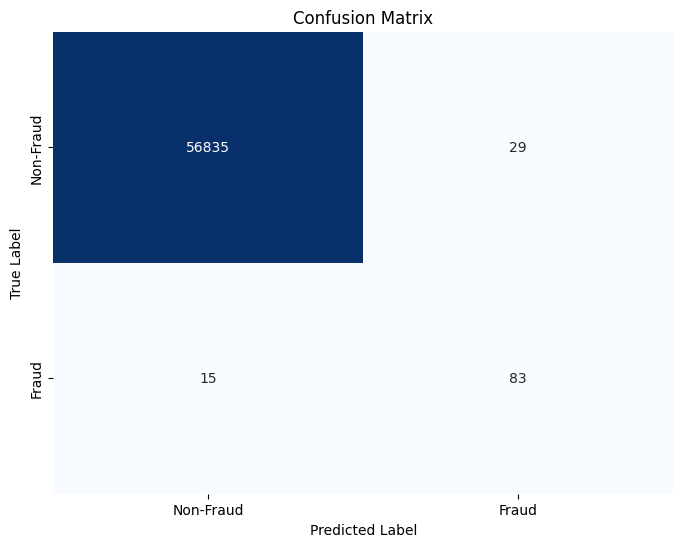

              precision    recall  f1-score       support
0              0.999736  0.999490  0.999613  56864.000000
1              0.741071  0.846939  0.790476     98.000000
accuracy       0.999228  0.999228  0.999228      0.999228
macro avg      0.870404  0.923214  0.895045  56962.000000
weighted avg   0.999291  0.999228  0.999253  56962.000000


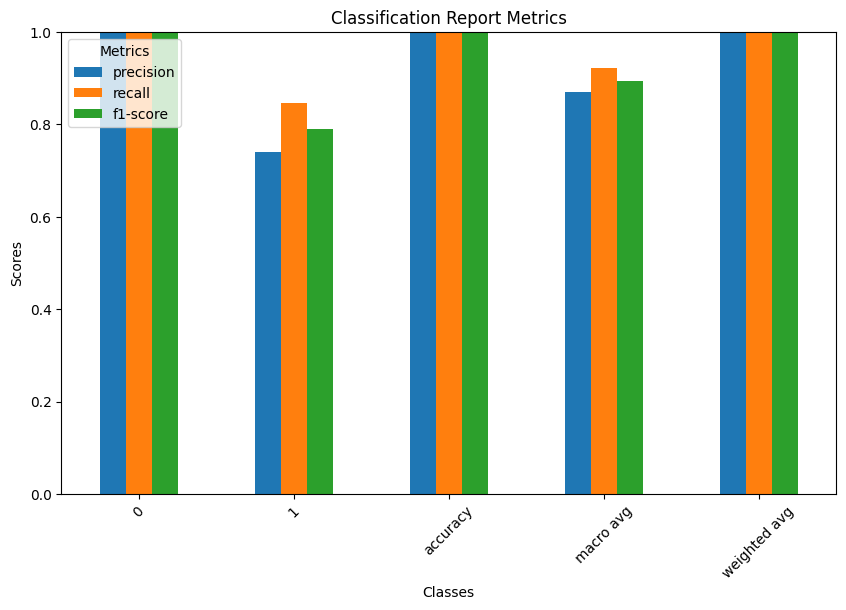

ROC AUC Score: 0.9615539906170685


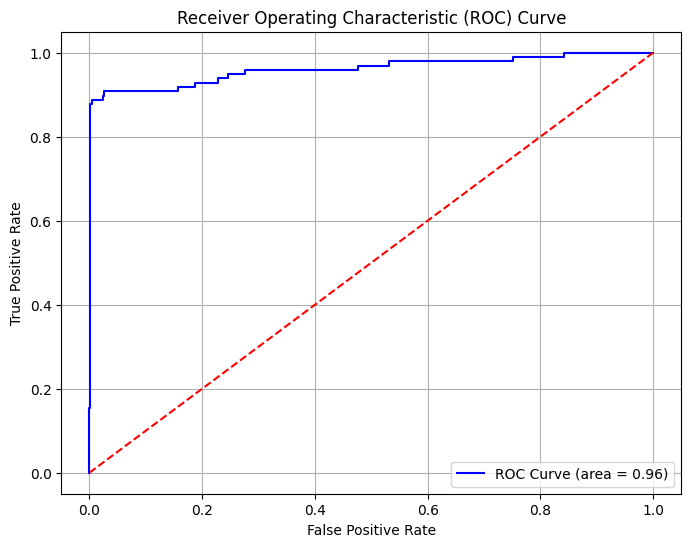


Model: Random Forest


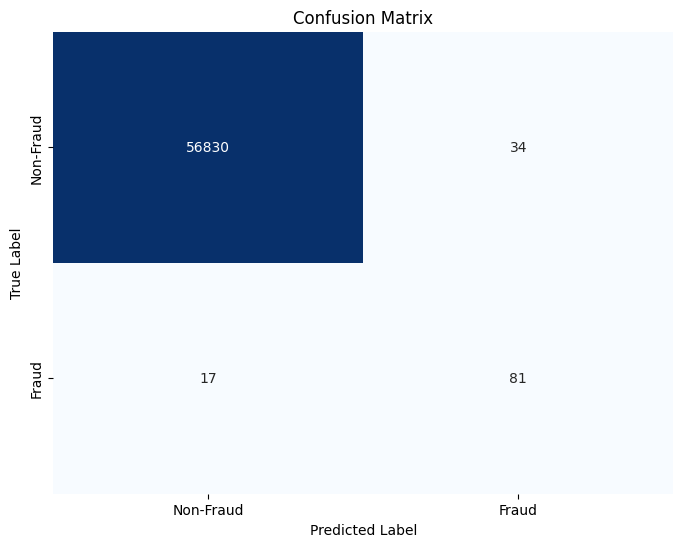

              precision    recall  f1-score       support
0              0.999701  0.999402  0.999551  56864.000000
1              0.704348  0.826531  0.760563     98.000000
accuracy       0.999105  0.999105  0.999105      0.999105
macro avg      0.852024  0.912966  0.880057  56962.000000
weighted avg   0.999193  0.999105  0.999140  56962.000000


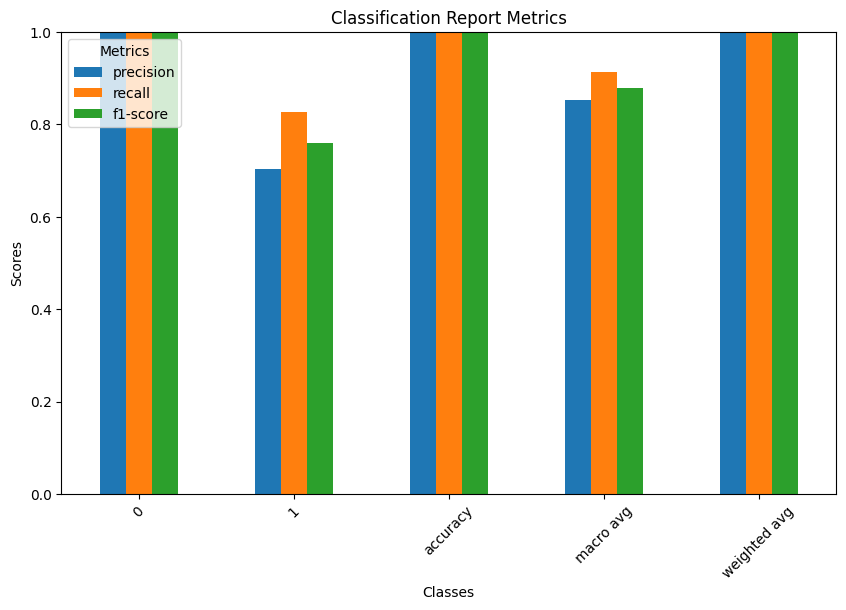

ROC AUC Score: 0.9582472286185155


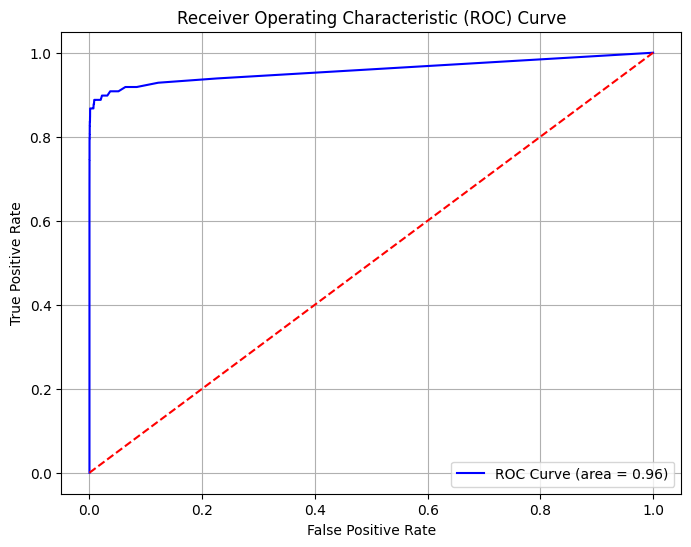


Model: Gradient Boosting


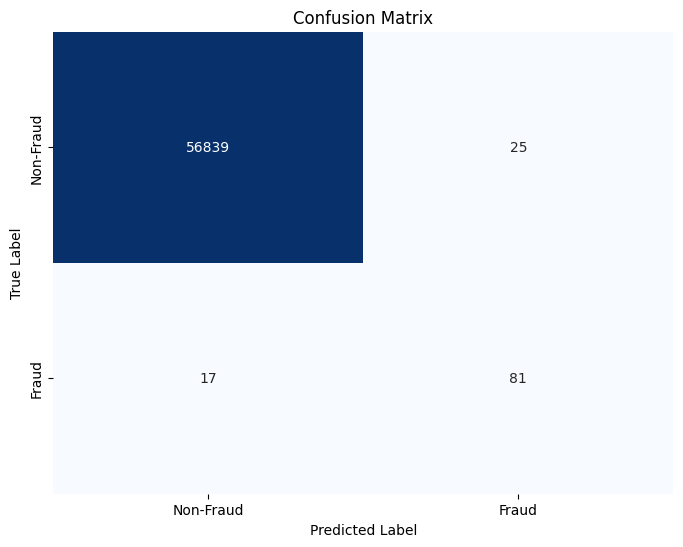

              precision    recall  f1-score       support
0              0.999701  0.999560  0.999631  56864.000000
1              0.764151  0.826531  0.794118     98.000000
accuracy       0.999263  0.999263  0.999263      0.999263
macro avg      0.881926  0.913045  0.896874  56962.000000
weighted avg   0.999296  0.999263  0.999277  56962.000000


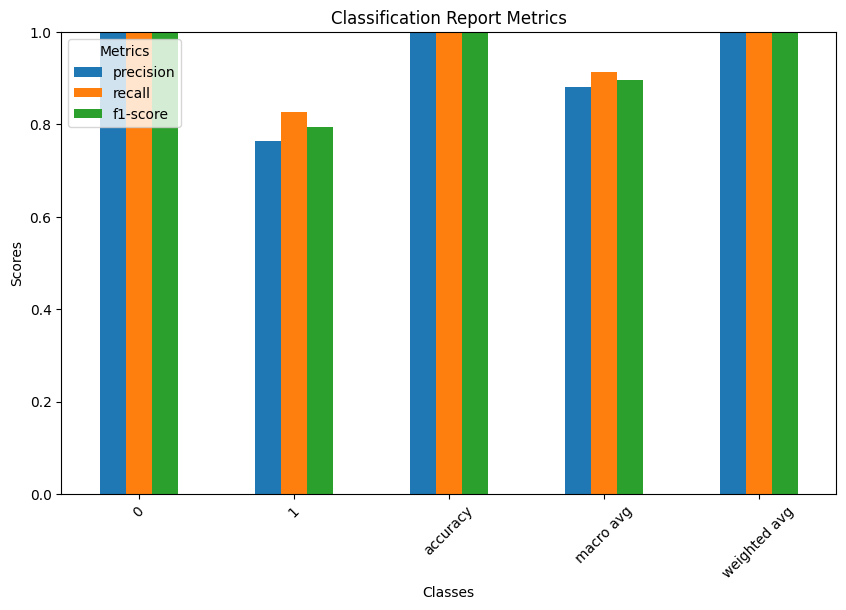

ROC AUC Score: 0.962737354719603


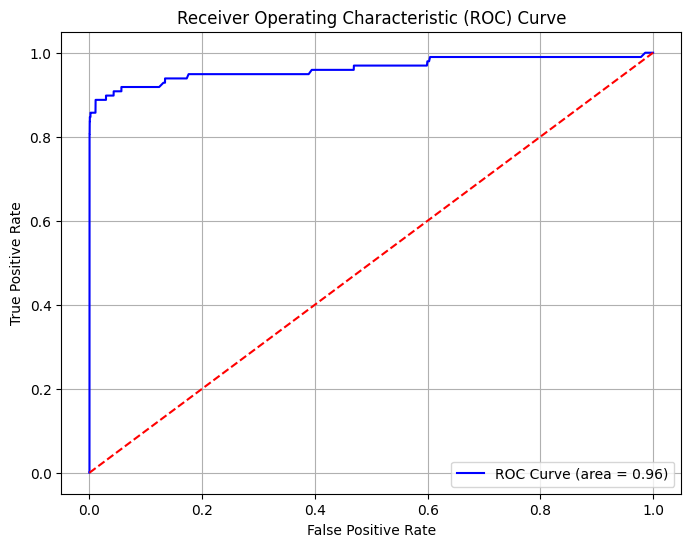

In [28]:
# Get class weights based on the training data
new_threshold = 0.7
class_weights = {0: 35, 1: 1}
sample_weights = np.array([class_weights[int(y)] for y in y_resampled])

# Train and evaluate each model with cost(weight)-sensitive learning
for model_name, model in models.items():
    # Training
    model.fit(X_resampled, y_resampled, sample_weight=sample_weights)

    # Making predictions on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= new_threshold).astype(int)

    # Evaluation metrics
    print(f'\nModel: {model_name}')
    plot_cm(confusion_matrix(y_test, y_pred))
    plot_report(classification_report(y_test, y_pred, output_dict=True))
    print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
    plot_roc_auc(y_test, y_proba)

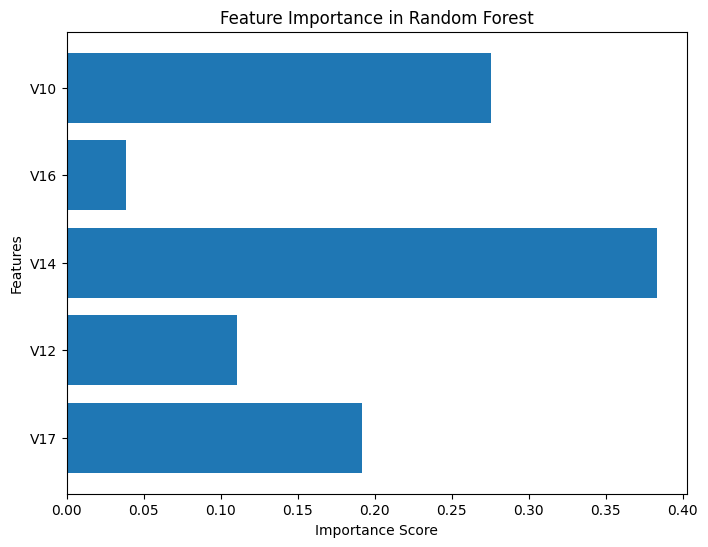

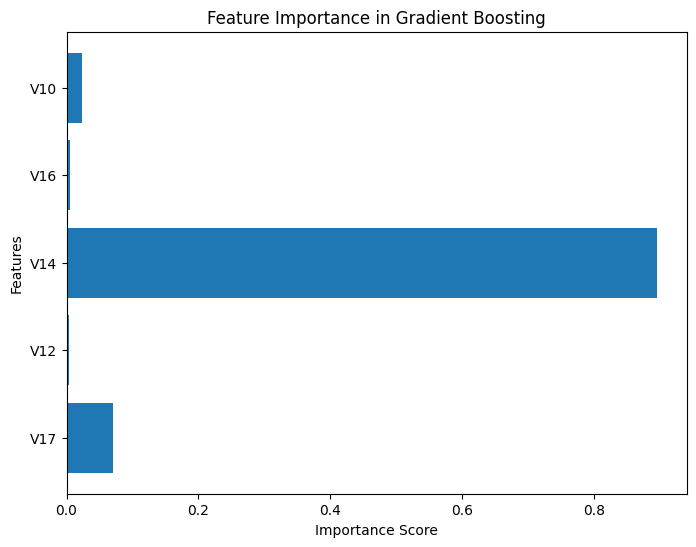

In [55]:
visualize_feature_importance(models)

#### Ensmble all models 


Model: VotingClassifier(lr, rf, gb)


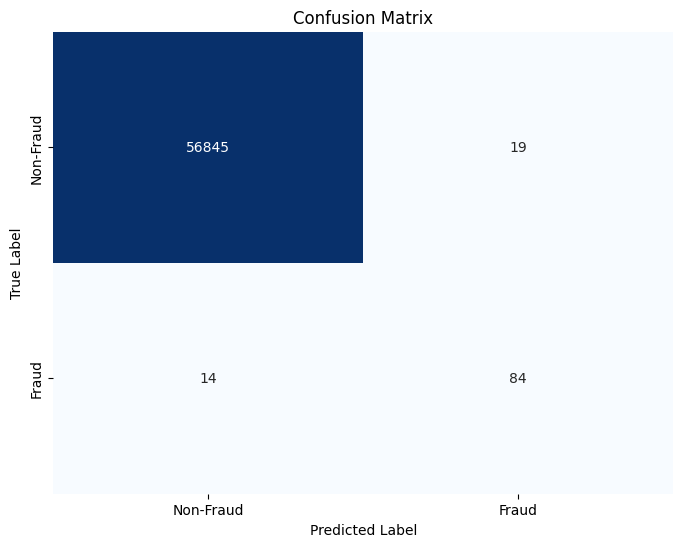

              precision    recall  f1-score       support
0              0.999754  0.999666  0.999710  56864.000000
1              0.815534  0.857143  0.835821     98.000000
accuracy       0.999421  0.999421  0.999421      0.999421
macro avg      0.907644  0.928404  0.917765  56962.000000
weighted avg   0.999437  0.999421  0.999428  56962.000000


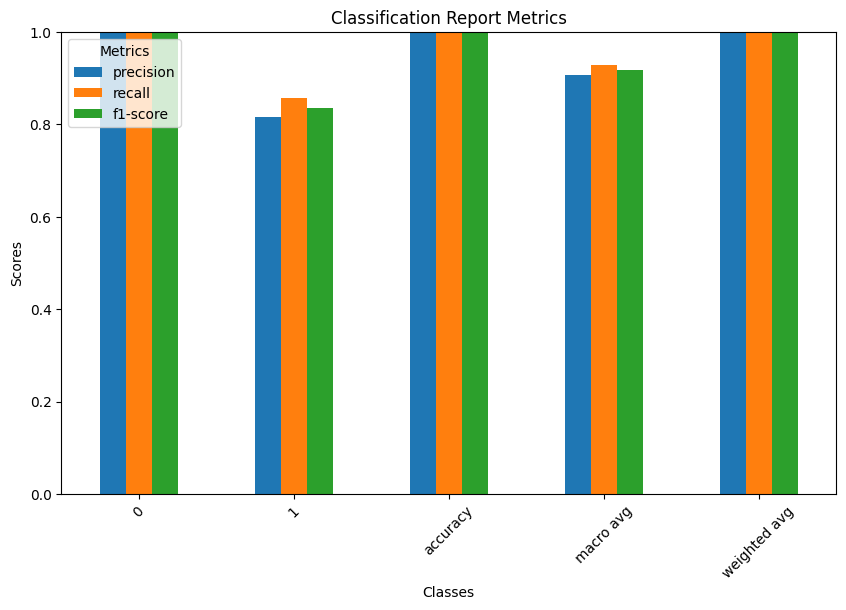

ROC AUC Score: 0.9633116752609879


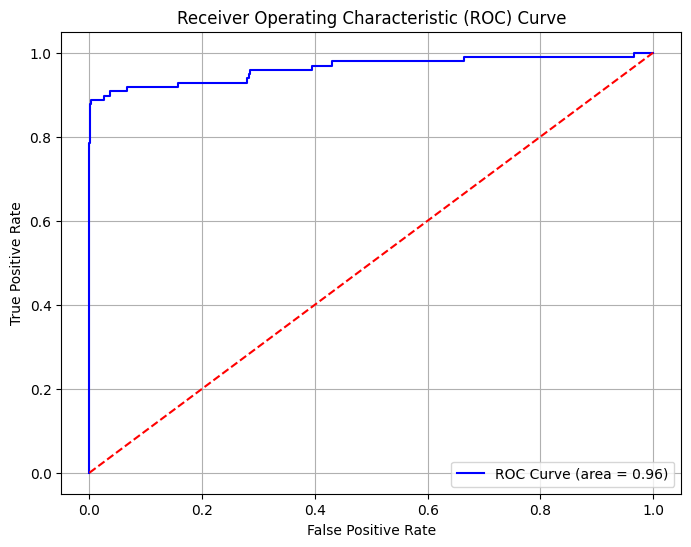

In [31]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('Logistic Regression', models["Logistic Regression"]), ('Random Forest', models["Random Forest"]), ('Gradient Boosting', models["Gradient Boosting"])],
    voting='soft'  # 'soft' voting uses predicted probabilities to make decisions
)

new_threshold = 0.7
class_weights = {0: 12, 1: 1}
sample_weights = np.array([class_weights[int(y)] for y in y_resampled])

# Training
voting_clf.fit(X_resampled, y_resampled, sample_weight=sample_weights)

# Making predictions on the test set
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred =  (y_proba >= new_threshold).astype(int)

# Evaluation metrics
print(f'\nModel: VotingClassifier(lr, rf, gb)')
plot_cm(confusion_matrix(y_test, y_pred))
plot_report(classification_report(y_test, y_pred, output_dict=True))
print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
plot_roc_auc(y_test, y_proba)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class FraudDetectionNN(nn.Module):
    def __init__(self, input_size):
        super(FraudDetectionNN, self).__init__()

        # Layers of the neural network
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),           # Input Layer
            nn.ReLU(),                           # Activation
            nn.BatchNorm1d(64),                  # Batch Normalization
            nn.Dropout(0.3),                     # Dropout Layer to prevent overfitting

            nn.Linear(64, 32),                   # Hidden Layer 1
            nn.ReLU(),                           # Activation
            nn.BatchNorm1d(32),                  # Batch Normalization
            nn.Dropout(0.3),                     # Dropout Layer

            nn.Linear(32, 16),                   # Hidden Layer 2
            nn.ReLU(),                           # Activation
            nn.BatchNorm1d(16),                  # Batch Normalization

            nn.Linear(16, 1),                    # Output Layer
            nn.Sigmoid()                         # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
X = ccf_df.drop('Class', axis=1)
y = ccf_df['Class']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1) # 1d tensor to 2d tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1) # 1d tensor to 2d tensor

In [11]:
# Initialize the model
input_size = X_train.shape[1]  # Number of input features
model = FraudDetectionNN(input_size)

# Loss function and optimizer
lossfn = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = lossfn(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.5875
Epoch [20/50], Loss: 0.5649
Epoch [30/50], Loss: 0.5475
Epoch [40/50], Loss: 0.5311
Epoch [50/50], Loss: 0.5137


Accuracy on test data: 0.9954


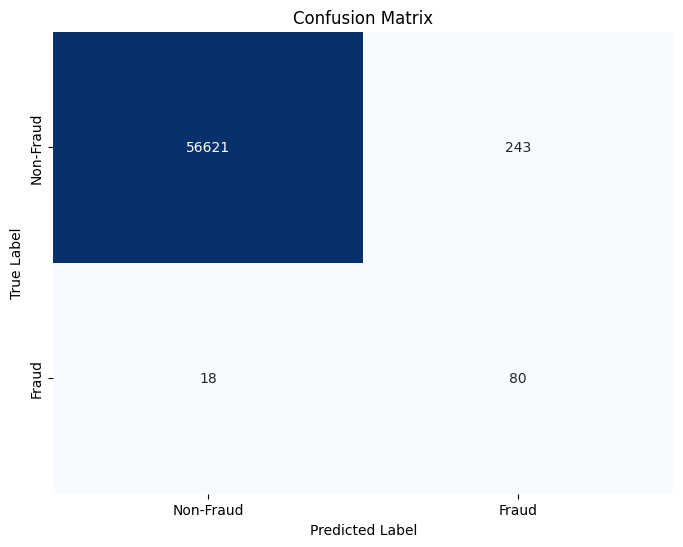

              precision    recall  f1-score       support
0.0            0.999682  0.995727  0.997701  56864.000000
1.0            0.247678  0.816327  0.380048     98.000000
accuracy       0.995418  0.995418  0.995418      0.995418
macro avg      0.623680  0.906027  0.688874  56962.000000
weighted avg   0.998388  0.995418  0.996638  56962.000000


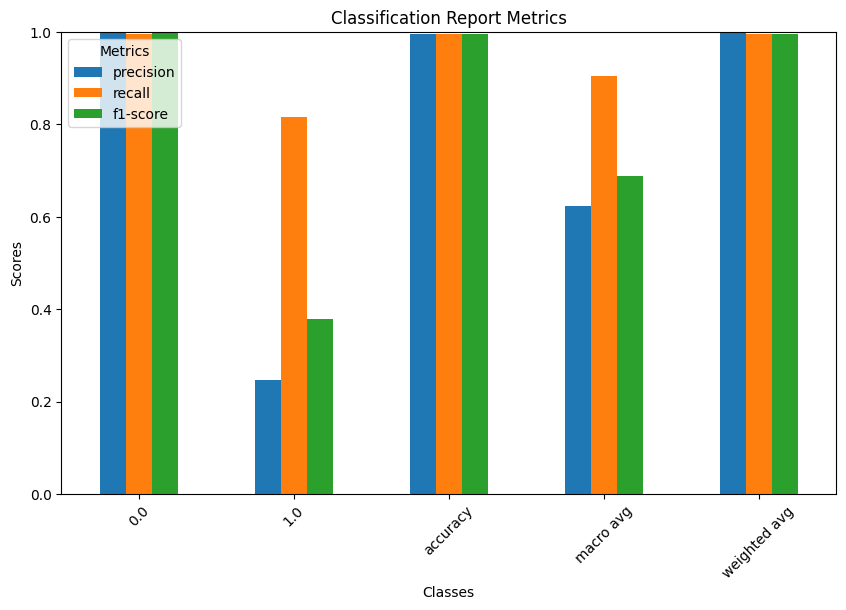

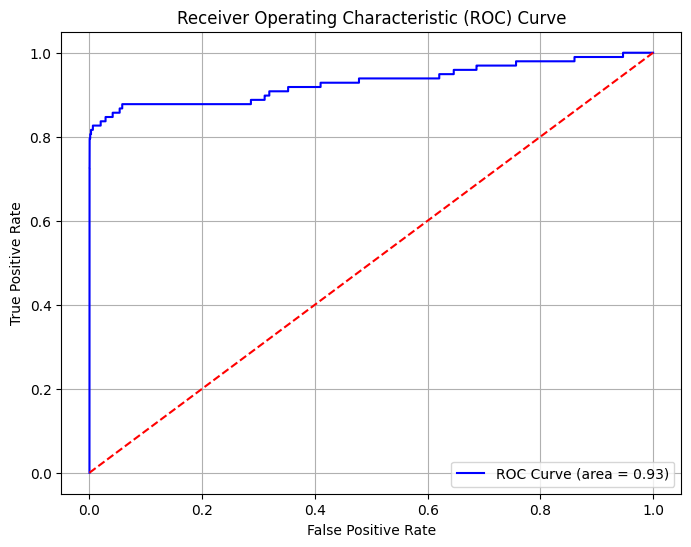

In [12]:
# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor) # Predicted probabilities
    test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary predictions

    # Convert tensors to numpy arrays
    y_test_array = y_test_tensor.cpu().numpy().flatten()
    test_predictions_array = test_predictions.cpu().numpy().flatten()
    test_proba_array = test_outputs.cpu().numpy().flatten()

    cm = confusion_matrix(
        y_test_array, 
        test_predictions_array
    )
    report = classification_report(
        y_test_array, 
        test_predictions_array, 
        output_dict=True
    )

    accuracy = (test_predictions == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy on test data: {accuracy:.4f}')
    plot_cm(cm)
    plot_report(report)
    plot_roc_auc(y_test_array, test_proba_array)

In [6]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

Confusion Matrix:


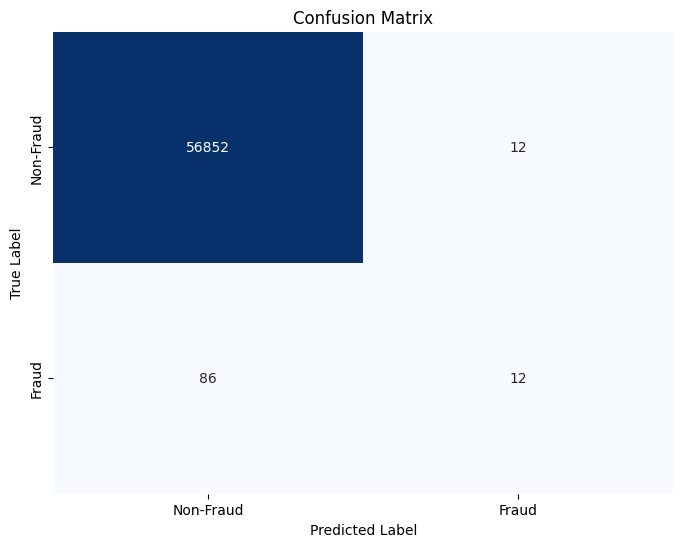


Classification Report:
              precision    recall  f1-score      support
0              0.998490  0.999789  0.999139  56864.00000
1              0.500000  0.122449  0.196721     98.00000
accuracy       0.998280  0.998280  0.998280      0.99828
macro avg      0.749245  0.561119  0.597930  56962.00000
weighted avg   0.997632  0.998280  0.997758  56962.00000


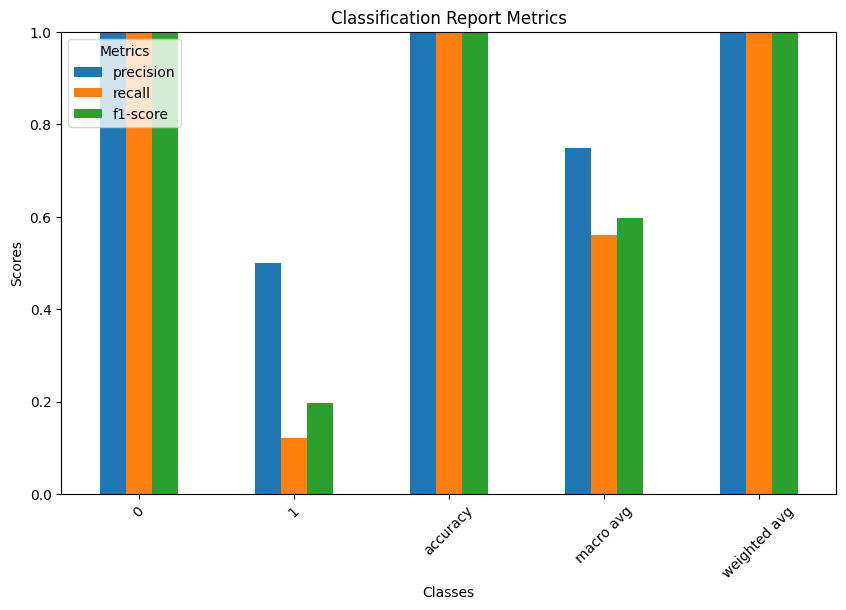


ROC AUC Score:


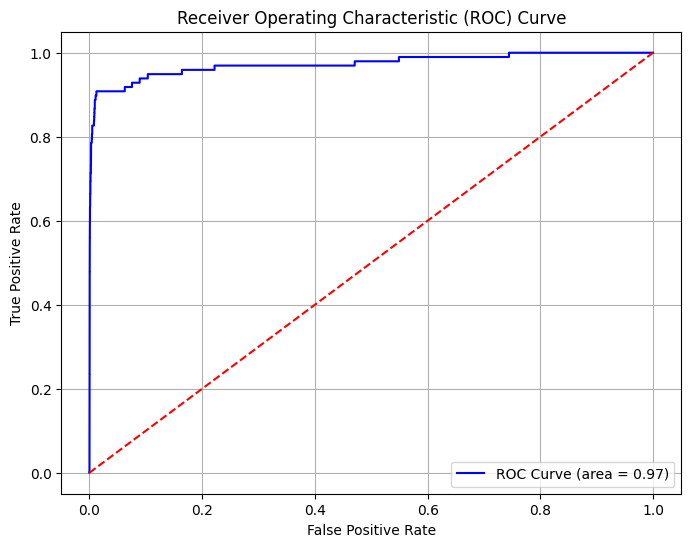

In [ ]:
new_threshold = 0.7

X = ccf_df.drop(columns=['Class'])  # Features (excluding the target 'Class')
y = ccf_df['Class']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the SVM model
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)  # RBF kernel for non-linearity
svm_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:, 1]  # For ROC-AUC, get probabilities for the positive class
y_pred = (y_proba > new_threshold).astype(int)

# Print evaluation metrics
print("Confusion Matrix:")
plot_cm(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
plot_report(classification_report(y_test, y_pred, output_dict=True))

roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC AUC Score:")
plot_roc_auc(y_test, y_proba)

In [7]:
# Plot decision boundary
def plot_svm_decision_boundary(X, y, model, title="SVM Decision Boundary (2D Projection)"):
    plt.figure(figsize=(10, 8))
    
    # Scatter plot of the classes
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="coolwarm", s=30, edgecolor="k")
    
    # Create a mesh to plot decision boundary
    xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit SVM on reduced data
svm_model_2d = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model_2d.fit(X_train_pca, y_train)

# Plot decision boundary for the training data
plot_svm_decision_boundary(X_train_pca, y_train, svm_model_2d, title="SVM Decision Boundary (PCA 2D Projection)")

In [ ]:
from sklearn.decomposition import KernelPCA

# Apply Kernel PCA
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=15, random_state=42)
X_kpca = kpca.fit_transform(X_train)

# Fit SVM on kernel PCA-transformed data
svm_model_kpca = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
print("Start")
svm_model_kpca.fit(X_kpca, y_train)
print("Stop")

# Plot decision boundary in kernel PCA-transformed space
print("Start")
plot_svm_decision_boundary(X_kpca, y_train, svm_model_kpca, title="SVM Decision Boundary (Kernel PCA 2D Projection)")
print("Stop")

MemoryError: Unable to allocate 387. GiB for an array with shape (227845, 227845) and data type float64

In [8]:
# Load and preprocess data as you’ve done for classical models
selected_features = ['V17', 'V12', 'V14', 'V16', 'V10']
X = ccf_df[selected_features].values
y = ccf_df['Class'].values

# Standardize the features to fit the encoding range
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from qiskit.circuit.library import ZZFeatureMap

# Define the Quantum Feature Map (e.g., ZZFeatureMap)
feature_map = ZZFeatureMap(feature_dimension=5, reps=2, entanglement='linear')

In [10]:
from qiskit_aer import Aer
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA

# Define the variational form (ansatz)
ansatz = RealAmplitudes(num_qubits=5, reps=2)

# Set up the backend and sampler for running simulations
# backend = Aer.get_backend('aer_simulator')
sampler = Sampler(options={"shots":1024, "seed":28})

# Define and initialize the VQC model
optimizer = COBYLA(maxiter=100)
vqc = VQC(feature_map=feature_map, ansatz=ansatz, optimizer=optimizer, sampler=sampler)

/tmp/ipykernel_179495/1600497997.py:12: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={"shots":1024, "seed":28})


In [ ]:
# Fit the model to the training data
vqc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = vqc.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# If the model supports probability, you can get probability estimates for ROC-AUC
if hasattr(vqc, "predict_proba"):
    y_proba = vqc.predict_proba(X_test)[:, 1]
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

## KDD 1999 Dataset

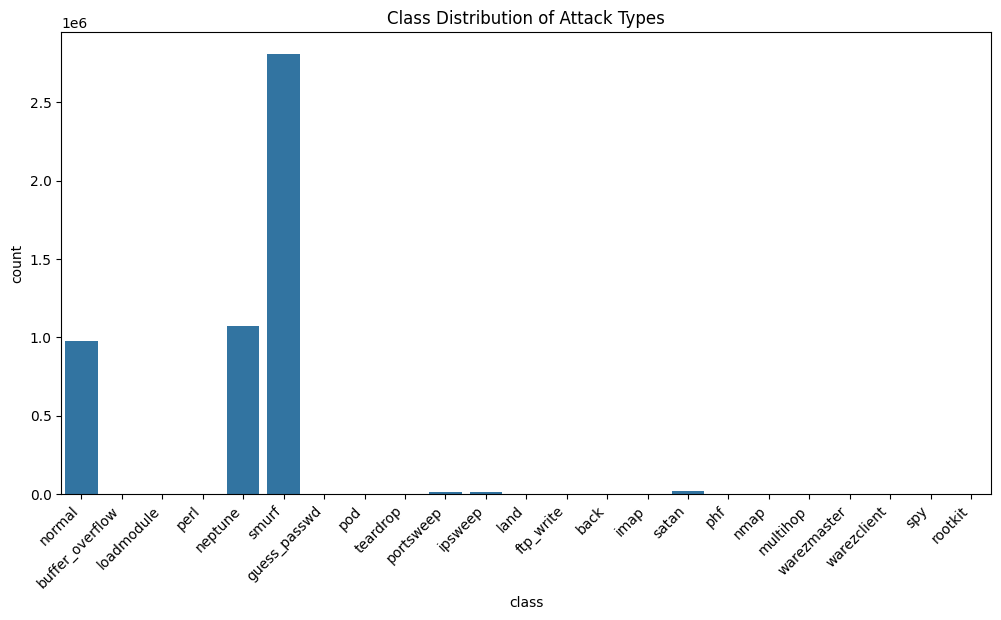

In [6]:
# 1. Class Imbalance Check
plt.figure(figsize=(12, 6))
sns.countplot(data=kdd_df, x='class')
plt.title('Class Distribution of Attack Types')
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
# 2. Feature Importance Analysis using Random Forest
# Converting categorical features into numerical for Random Forest analysis
le_protocol = LabelEncoder()
kdd_df['protocol_type'] = le_protocol.fit_transform(kdd_df['protocol_type'])

le_service = LabelEncoder()
kdd_df['service'] = le_service.fit_transform(kdd_df['service'])

le_flag = LabelEncoder()
kdd_df['flag'] = le_flag.fit_transform(kdd_df['flag'])

In [14]:
le_class = LabelEncoder()
kdd_df['class'] = le_class.fit_transform(kdd_df['class'])

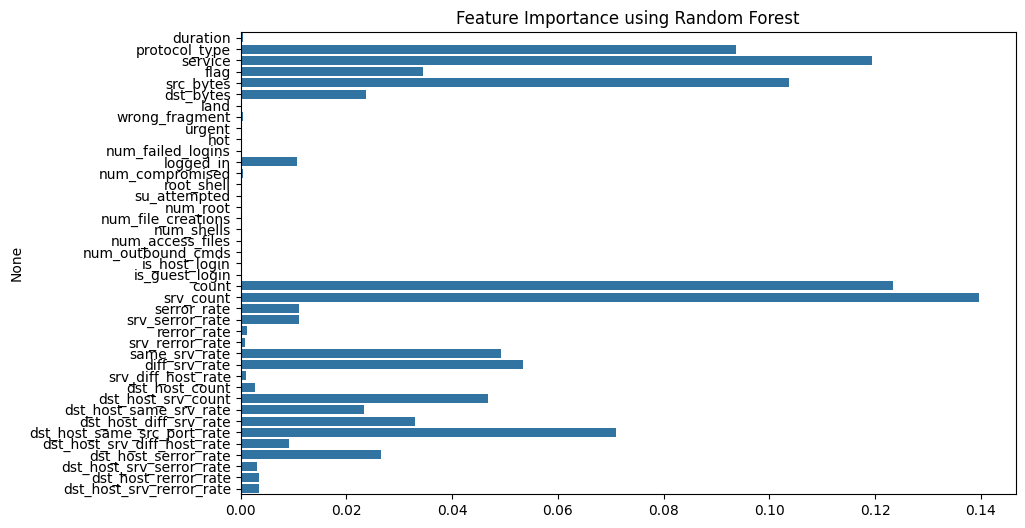

In [7]:
# Train Random Forest to find feature importance
X = kdd_df.drop(columns=['class'])
y = kdd_df['class']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importance using Random Forest')
plt.show()

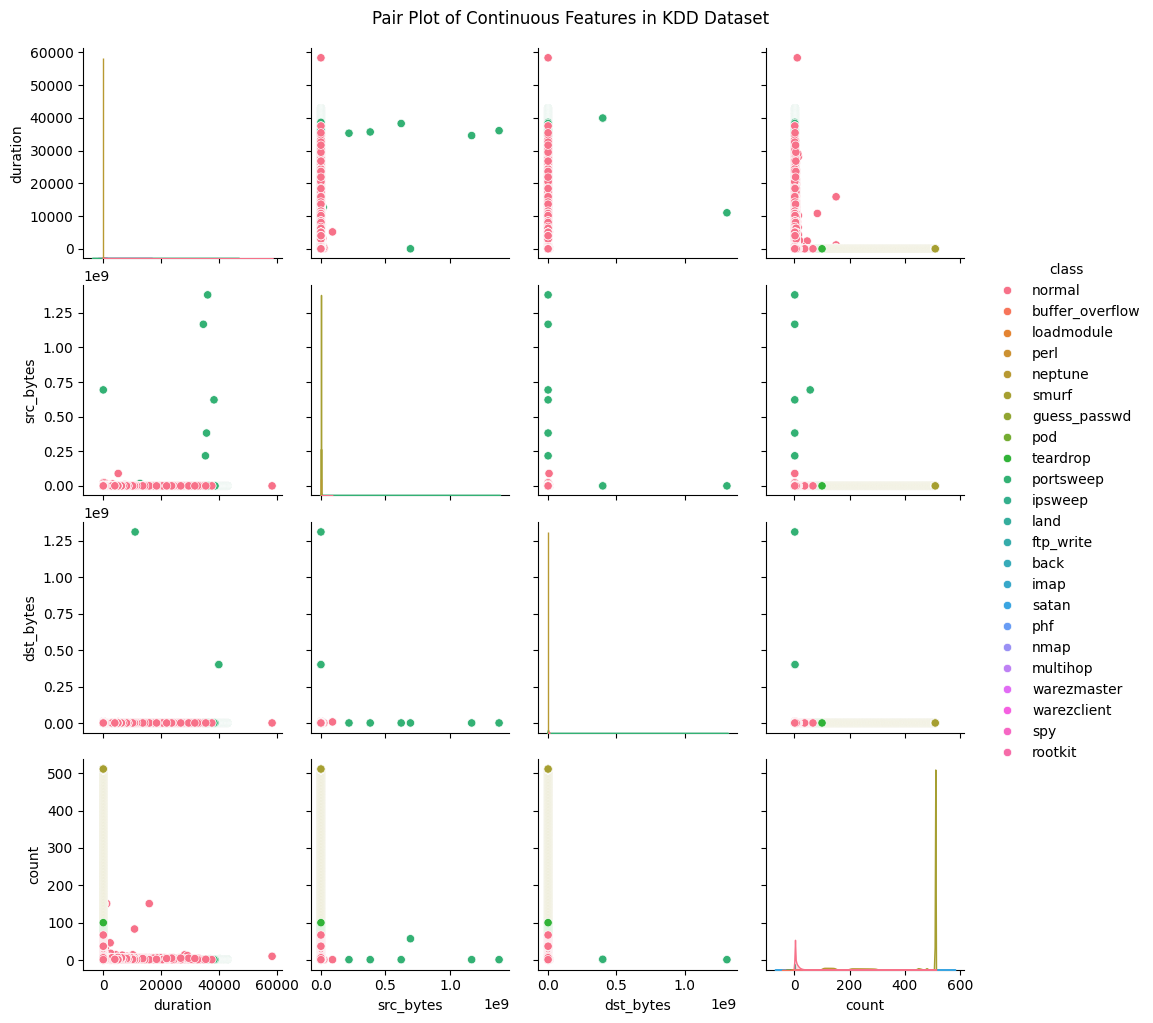

In [5]:
# 3. Pair Plot Analysis of Continuous Features
subset_features = ['duration', 'src_bytes', 'dst_bytes', 'count']
sns.pairplot(kdd_df[subset_features + ['class']], hue='class', diag_kind='kde')
plt.suptitle('Pair Plot of Continuous Features in KDD Dataset', y=1.02)
plt.show()

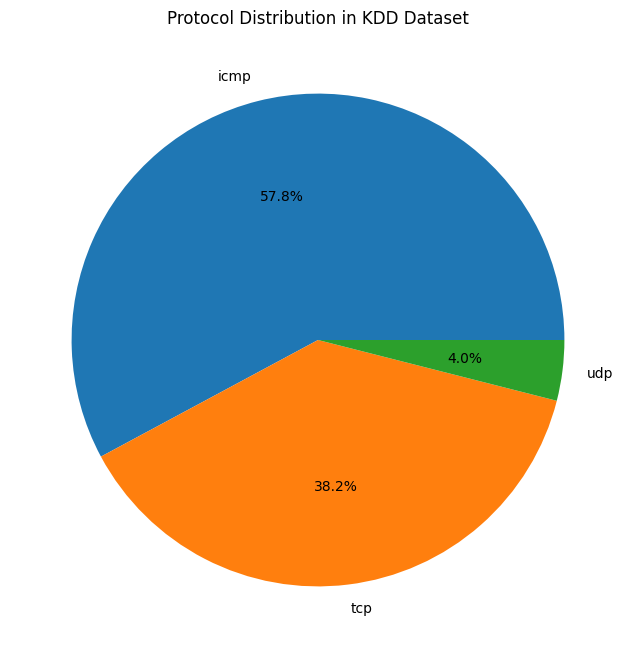

In [6]:
# 4. Protocol Analysis
protocol_counts = kdd_df['protocol_type'].value_counts()
protocol_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Protocol Distribution in KDD Dataset')
plt.ylabel('')
plt.show()

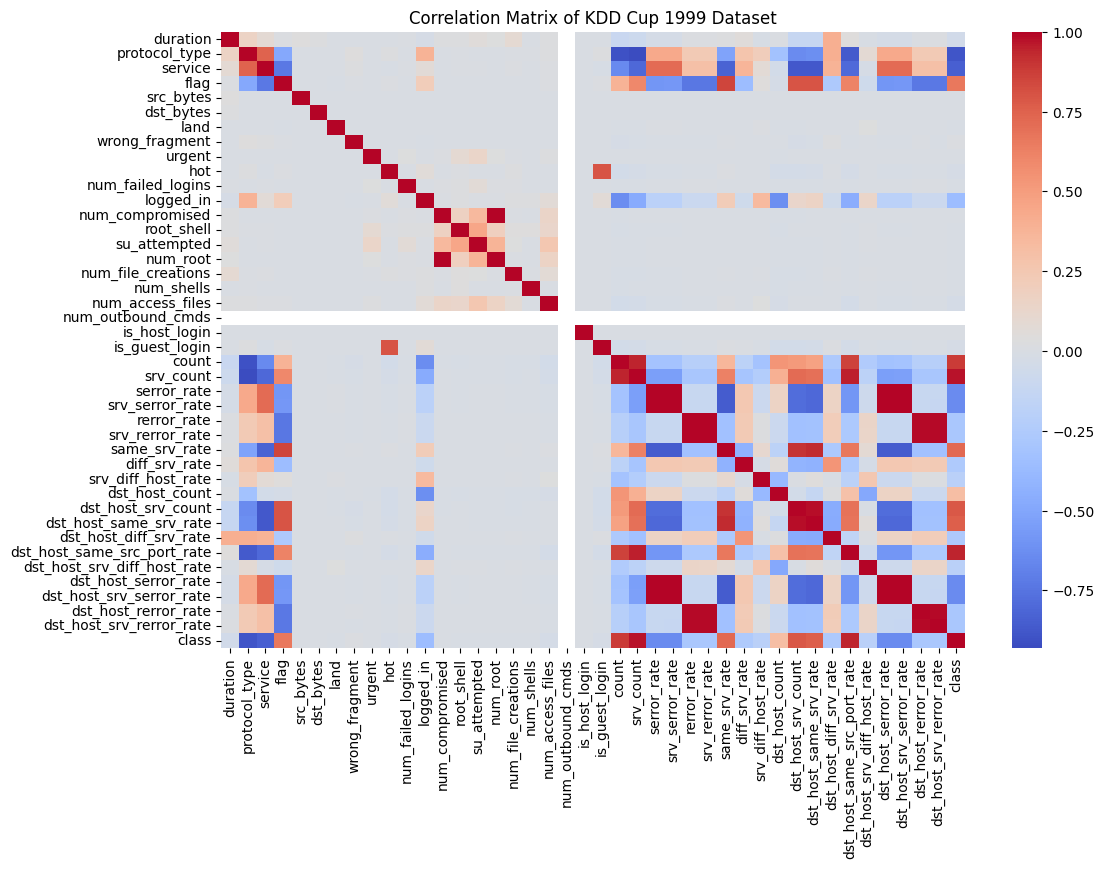

In [15]:
# 5. Heatmap of Correlations
plt.figure(figsize=(12, 8))
corr_matrix = kdd_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of KDD Cup 1999 Dataset')
plt.show()

In [24]:
# Assigning column names as per dataset description
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
           "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
           "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
           "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
           "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
           "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
           "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
           "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
           "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

kdd_df.columns = columns

# Step 1: Data Preprocessing for Quantum Embedding
# Normalize continuous features for quantum processing
continuous_features = ["duration", "src_bytes", "dst_bytes", "count", "srv_count"]
kdd_df[continuous_features] = (kdd_df[continuous_features] - kdd_df[continuous_features].mean()) / kdd_df[continuous_features].std()

# Take a subset of data for visualization to avoid computational overload
subset_data = kdd_df[continuous_features].values[:100]  # Use the first 100 samples

# Step 2: Quantum Feature Map to Embed Data into Quantum State
feature_map = ZZFeatureMap(feature_dimension=len(continuous_features), reps=2, entanglement='linear')

# Create quantum circuits for each data point
quantum_circuits = []
for datapoint in subset_data:
    circuit = feature_map.assign_parameters(datapoint)
    quantum_circuits.append(circuit)

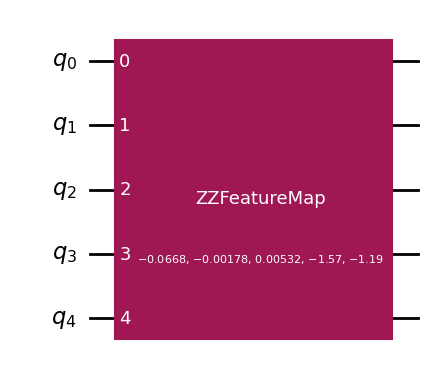

In [25]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

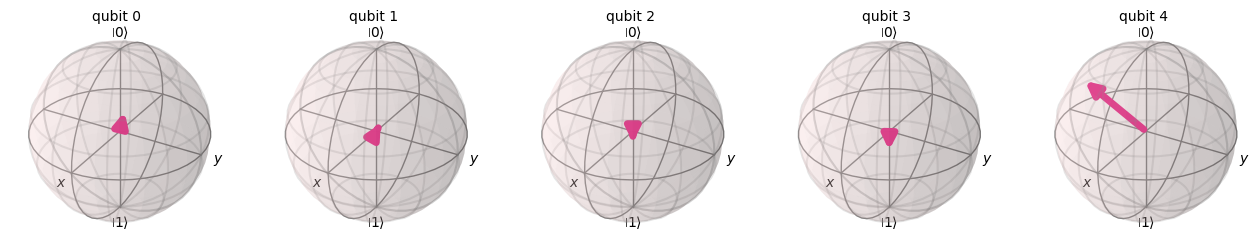

In [26]:
# Step 3: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first data point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

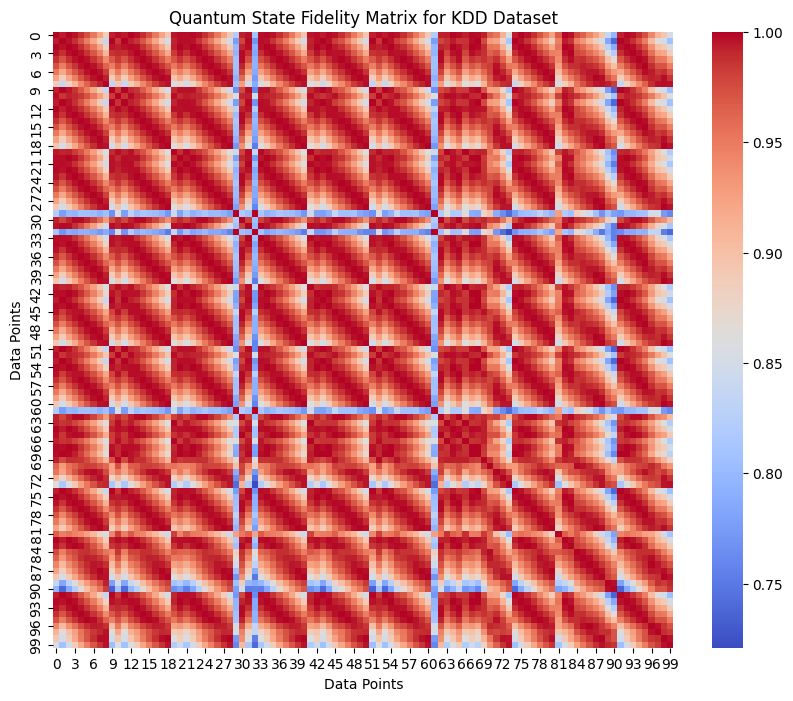

In [27]:
# Step 4: Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(subset_data), len(subset_data)))

for i in range(len(subset_data)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(subset_data)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation

# Step 5: Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix for KDD Dataset')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

## PIMA Diabetes Dataset

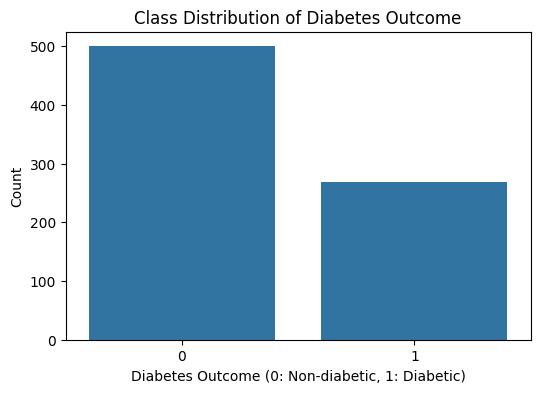

In [16]:
# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=diabetes_df, x='Outcome')
plt.title('Class Distribution of Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0: Non-diabetic, 1: Diabetic)')
plt.ylabel('Count')
plt.show()

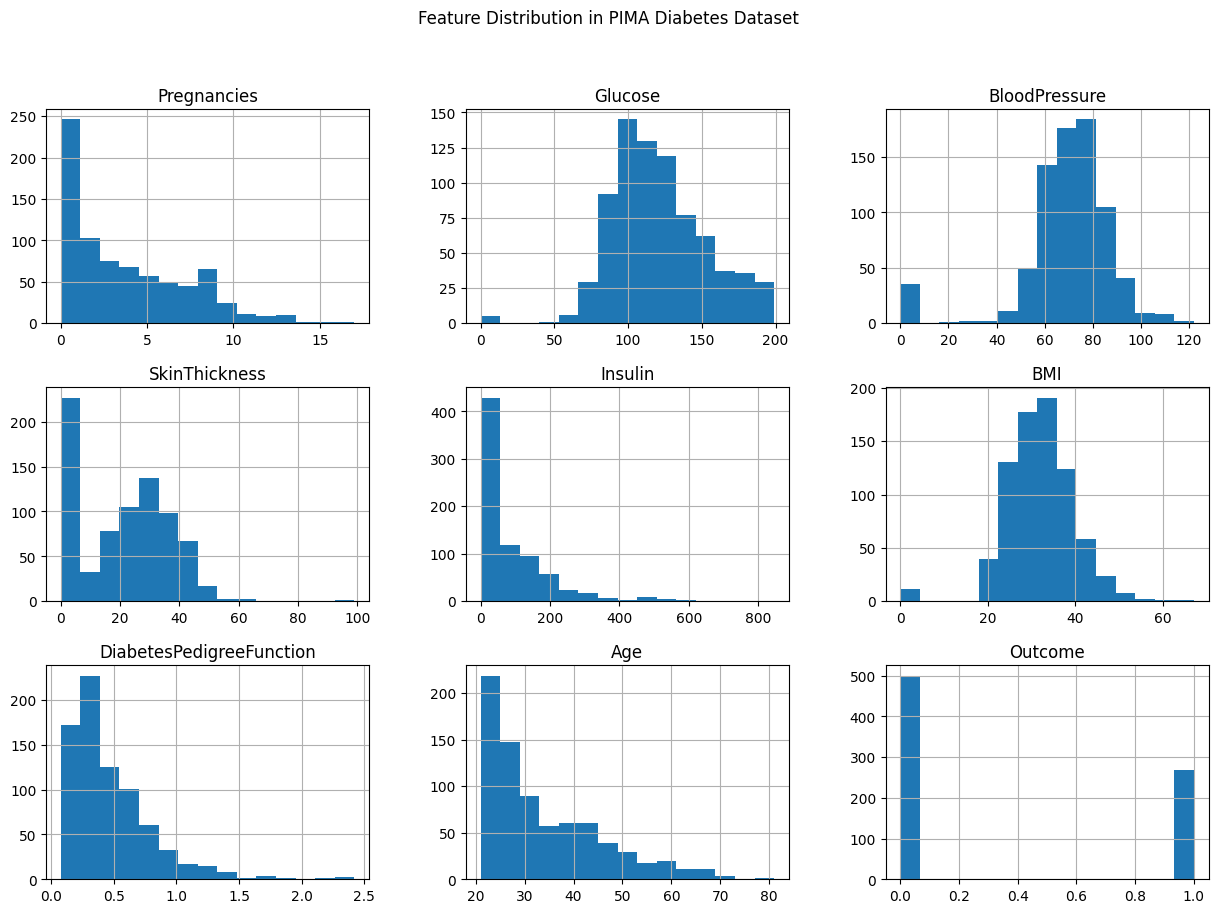

In [17]:
# 2. Histograms for Feature Distribution
diabetes_df.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Feature Distribution in PIMA Diabetes Dataset')
plt.show()

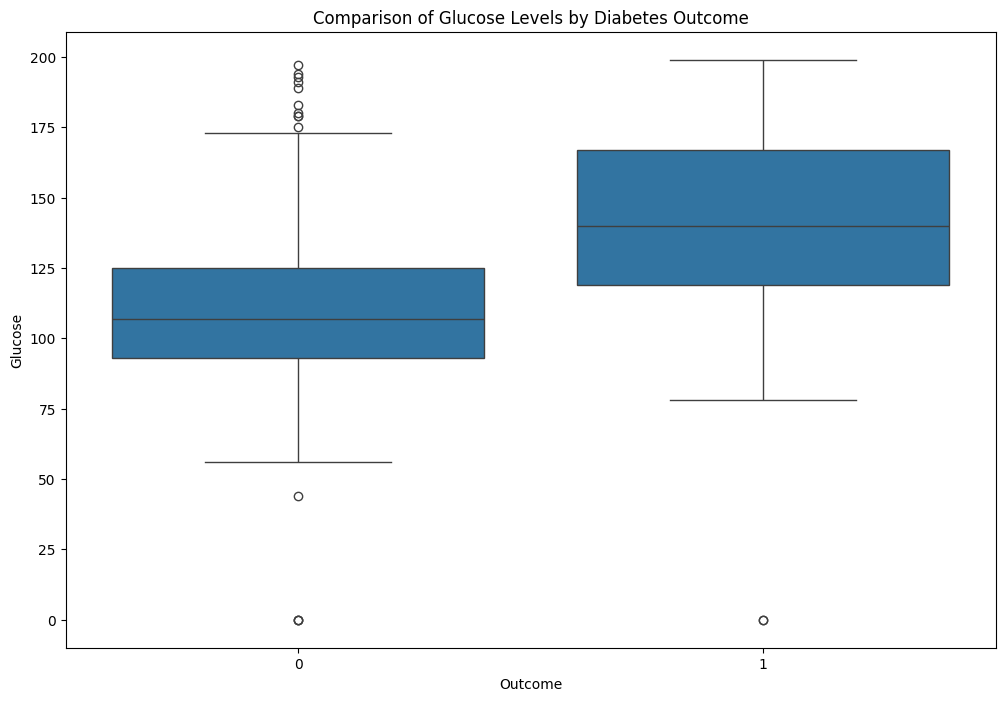

In [18]:
# 3. Box Plots for Feature Comparisons by Outcome
plt.figure(figsize=(12, 8))
sns.boxplot(data=diabetes_df, x='Outcome', y='Glucose')
plt.title('Comparison of Glucose Levels by Diabetes Outcome')
plt.show()

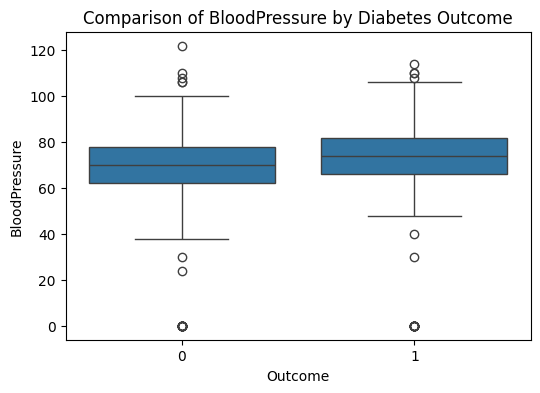

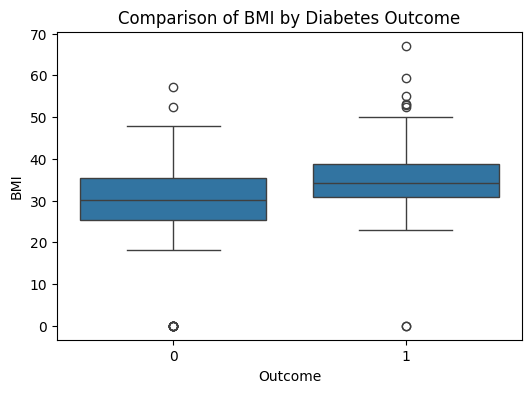

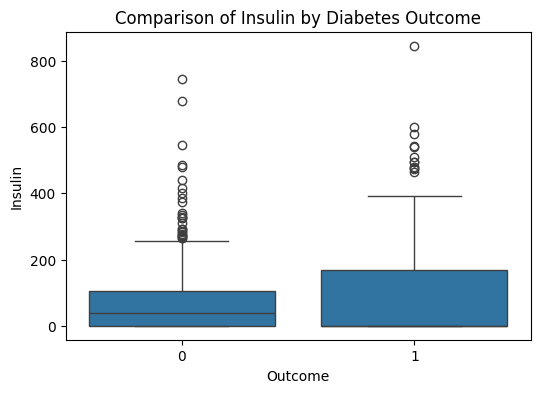

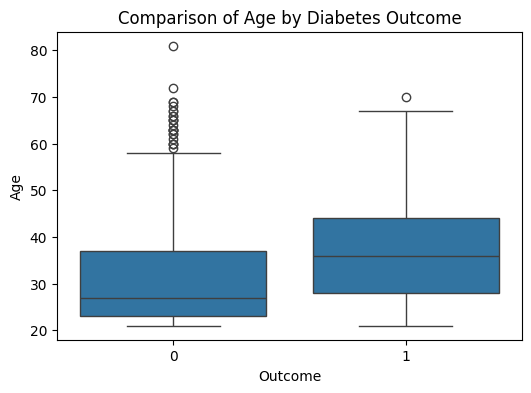

In [19]:
# Box plots for other continuous features
continuous_features = ['BloodPressure', 'BMI', 'Insulin', 'Age']
for feature in continuous_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=diabetes_df, x='Outcome', y=feature)
    plt.title(f'Comparison of {feature} by Diabetes Outcome')
    plt.show()

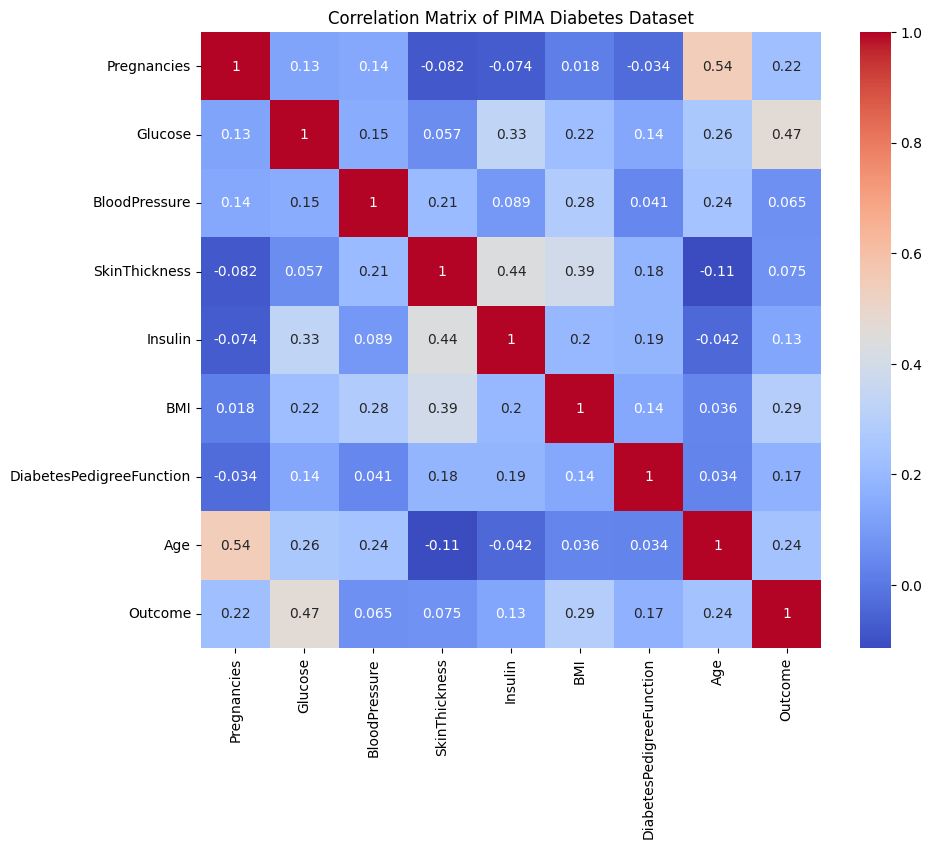

In [20]:
# 4. Correlation Matrix (Heatmap)
plt.figure(figsize=(10, 8))
corr_matrix_diabetes = diabetes_df.corr()
sns.heatmap(corr_matrix_diabetes, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of PIMA Diabetes Dataset')
plt.show()

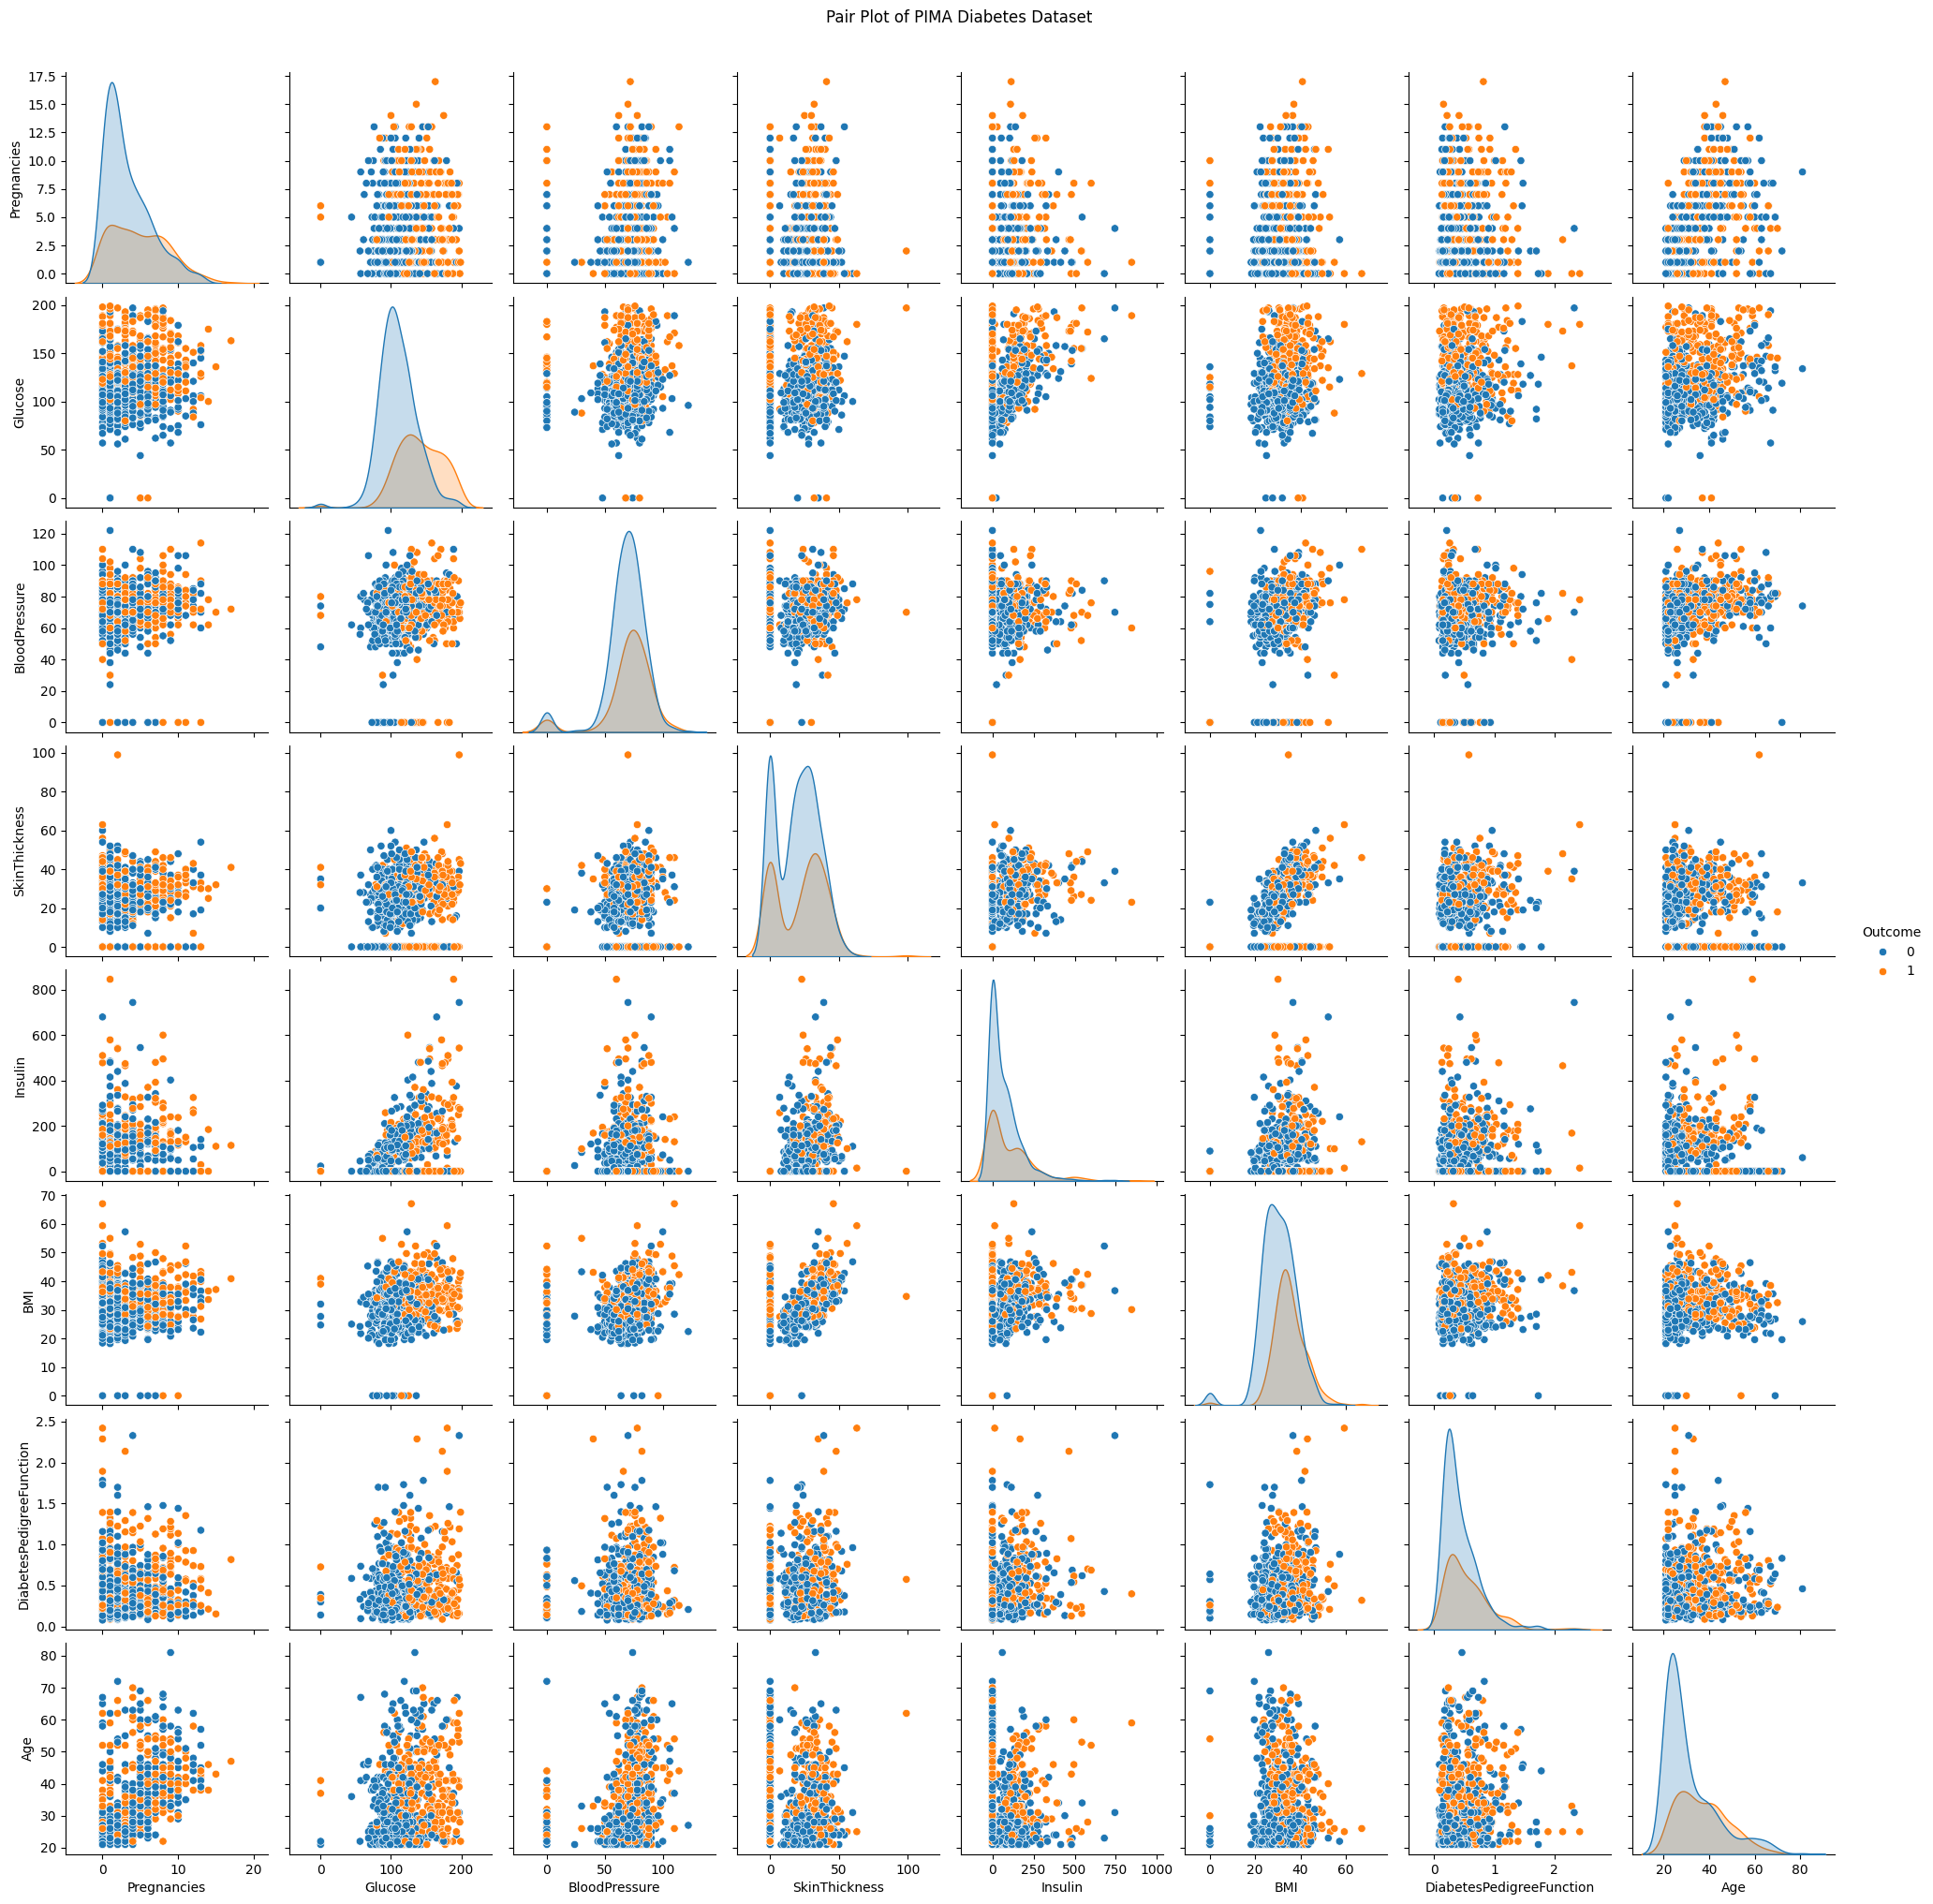

In [21]:
# 5. Pair Plot of Features Colored by Outcome
sns.pairplot(diabetes_df, hue='Outcome', diag_kind='kde')
plt.suptitle('Pair Plot of PIMA Diabetes Dataset', y=1.02)
plt.show()

In [28]:
# Step 2: Data Preprocessing for Quantum Embedding
# Normalizing continuous features for quantum processing
continuous_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
                       'DiabetesPedigreeFunction', 'Age']
diabetes_df[continuous_features] = (diabetes_df[continuous_features] - diabetes_df[continuous_features].mean()) / diabetes_df[continuous_features].std()

# Taking a subset of data for visualization to avoid computational overload
subset_data = diabetes_df[continuous_features].values[:100]  # Use the first 100 samples

# Step 3: Quantum Feature Encoding using ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=len(continuous_features), reps=2, entanglement='linear')

# Create quantum circuits for each data point
quantum_circuits = []
for datapoint in subset_data:
    circuit = feature_map.assign_parameters(datapoint)
    quantum_circuits.append(circuit)


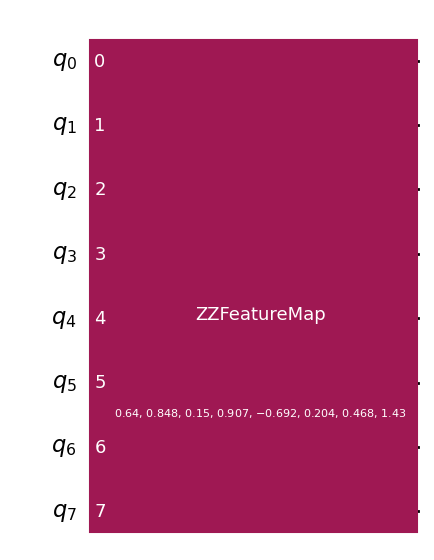

In [29]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

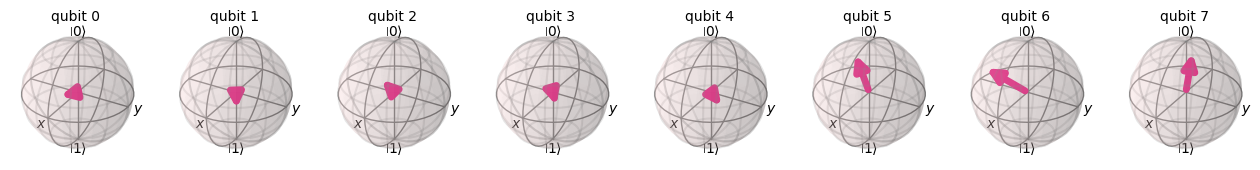

In [30]:
# Step 4: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first data point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

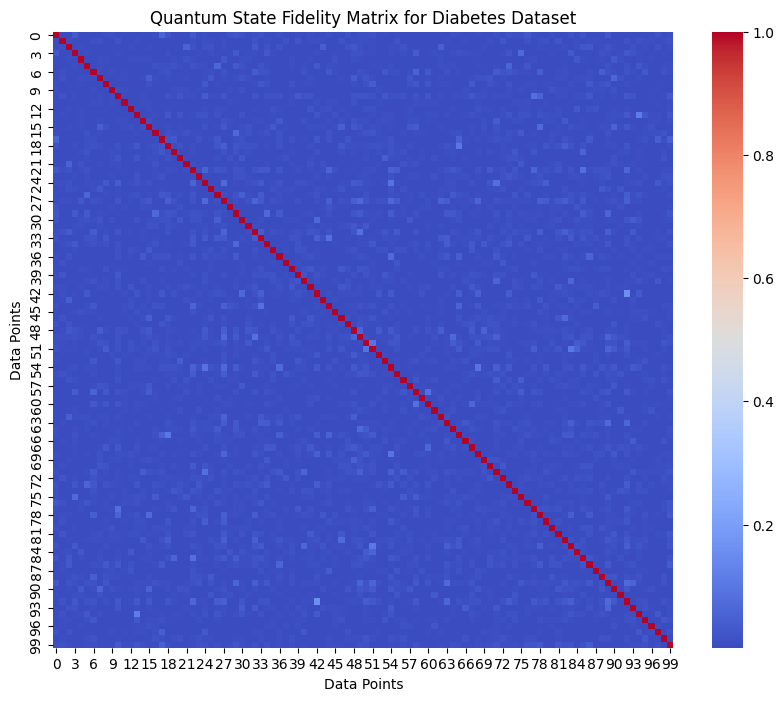

In [31]:
# Step 5: Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(subset_data), len(subset_data)))

for i in range(len(subset_data)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(subset_data)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation

# Step 6: Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix for Diabetes Dataset')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()